In [1]:
# Importing core libraries required for the case study
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option("display.max_rows", 50)
warnings.filterwarnings('ignore')

In [2]:
loan_csv = "loan.csv"

df_loan = pd.read_csv(loan_csv, low_memory=False)
df_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


<h1>Data Cleaning</h1>

In [3]:
""" 
By looking at the table we can see there are so many columns are present which Null values in all the rows. So it doest make sense to use them.
So we will just drop them all.
"""
#intial data shape (39717, 111)
df_loan = df_loan.dropna(axis=1, how='all')
#after removing data shape (39717, 57)

In [4]:
"""
We will also check for duplicates row. if we have it then we can remove those
"""
dups_data = len(df_loan[df_loan.duplicated()])
if dups_data == 0:
    print("good to go")
else:
    print("Fix me up daddy!")

#response -> good to go    

good to go


In [5]:
df_loan.isnull().sum()
""" 
By looking at this results we can see we still have some columns which has large number of nan values so we also have to remove them.
So we will setup some threshold . if we have null values beyond that threshold lets say 70% than we will just drop those columns.
"""
threshold = len(df_loan) * 0.5
df_loan.dropna(thresh=threshold, axis=1, inplace=True)
df_loan.shape


(39717, 54)

### Data Dictionary

In [6]:
data_dict = pd.read_excel('Data_Dictionary.xlsx')
data_dict

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
112,verification_status,"Indicates if income was verified by LC, not ve..."
113,verified_status_joint,Indicates if the co-borrowers' joint income wa...
114,zip_code,The first 3 numbers of the zip code provided b...
115,NaN,NaN


In [7]:
"""
Dropping these following columns which explanation.
-> url : it contains some static link with some id which has no relation so there is no need to take in consideration.
-> Removing text/description columns which wont contribute to overall analysis.
-> emp_title: While the employer_title column might initially seem useful, as titles like "Senior Product Manager" or "Senior Sales Manager" could potentially provide insights into the applicant's financial stability, it 
            presents challenges for analysis. The dataset includes a wide variety of job titles, making it difficult to draw meaningful conclusions or create consistent categories based on occupation alone. 
            Due to this high variability and the lack of a clear way to categorize or analyze these titles effectively, we have decided to drop this column from our analysis.
"""
df_loan.drop(['url', 'emp_title', 'desc', 'title'],  axis=1, inplace=True)

In [8]:
df_loan['member_id'].value_counts().sum() == len(df_loan)
#response -> True
"""
These columns are typically used for indexing or tracking individual records but don't contribute to decision making of loan approvals. Hence, they can be safely dropped.
"""
df_loan.drop(['member_id'], axis=1, inplace=True)

In [9]:
df_loan['loan_status']
"""
After looking at loan status we can there many loan which are still in progress. So in terms of deciding factors we cannot use those data until those loans are fully paid so,
we gotta drop rows with loan status = Current
"""
df_loan.drop(df_loan[df_loan['loan_status'] == 'Current'].index, inplace=True)

In [10]:
df_loan.shape

(38577, 49)

In [11]:
# Check for columns with the same value in every row
columns_with_constant_values = df_loan.columns[df_loan.nunique() == 1]

# Display columns with constant values
print(f"Columns with the same value in every row: {list(columns_with_constant_values)}")
df_loan = df_loan.drop(columns=columns_with_constant_values)


Columns with the same value in every row: ['pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


In [12]:
"""
These columns mostly capture the borrower’s behavior after the loan is approved, like payments, outstanding balances, and credit pull dates. Since this data isn’t available when deciding whether to approve a loan, 
it would lead to inaccurate results if included. We should focus on data that exists before loan approval, like credit history and income. So again we are dropping it.
"""
df_loan = df_loan.drop(['delinq_2yrs', 'earliest_cr_line', 
                          'inq_last_6mths', 'open_acc', 'pub_rec', 
                          'revol_bal', 'revol_util', 'total_acc', 
                          'total_pymnt', 
                          'total_pymnt_inv', 'total_rec_prncp', 
                          'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                          'collection_recovery_fee', 'last_pymnt_d', 
                          'last_pymnt_amnt', 'last_credit_pull_d' 
                          ],  axis=1)
df_loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'pub_rec_bankruptcies'],
      dtype='object')

In [13]:
"""
We will also remove few columns which have all the rows filled with value 0 so we cannot consider it in decision making.
"""
columns_with_all_zeros = df_loan.columns[(df_loan == 0).all()]
df_loan = df_loan.drop(columns=columns_with_all_zeros)

In [14]:
df_loan.shape

(38577, 20)

In [15]:
#We still have many columns with null values but to fill those empty cells we need to first convert the data in correct data type.

<h1>Data Cleansing </h1>

In [16]:
## Fixing Data types of Columns, Rounding off to 2 decimals.
# remove % from string
df_loan['int_rate'] = df_loan['int_rate'].apply(lambda x : float(x[:-1]))
# str to int
df_loan['term'] = df_loan['term'].apply(lambda x : int(x.replace(" months", "")))
# string to datetime
df_loan['issue_d'] = pd.to_datetime(df_loan['issue_d'], format='%b-%y')
# rounding off values
df_loan['loan_amnt'] = df_loan['loan_amnt'].apply(lambda x: round(x,2))
df_loan['dti'] = df_loan['dti'].apply(lambda x: round(x,2))
df_loan["funded_amnt"] = df_loan["funded_amnt"].apply(lambda x: round(x,2))
df_loan["int_rate"] = df_loan['int_rate'].apply(lambda x: round(x,2))
df_loan['funded_amnt_inv'] = df_loan["funded_amnt_inv"].apply(lambda x: round(x,2))

In [17]:
df_loan.isnull().sum()

# As we can see here we still got 5 columns which contains null values = ['emp_length', 'pub_rec_bankruptcies']
# we can drop 4 columns out of above 5 because the it doesnt have large numbers of empty rows as compare to total dataset.
# df_loan.columns
df_loan = df_loan.dropna(subset=['pub_rec_bankruptcies'])

In [18]:
# Now we just have to think about emp_length column
df_loan.emp_length.value_counts()
# From response we can see there are people from in between 0 to 10 years of experience. so we can convert them in numbers and fill average of it into the empty cells.
mapping = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}
df_loan['emp_length'] = df_loan['emp_length'].replace(mapping)

df_loan['emp_length'] = pd.to_numeric(df_loan['emp_length'], errors='coerce')

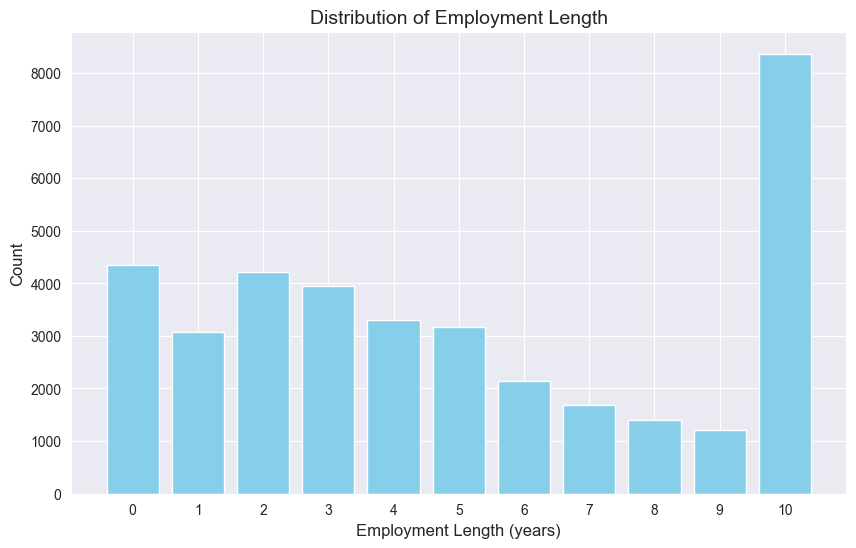

In [19]:
#now 
df_loan.emp_length.value_counts()
emp_length_counts = df_loan['emp_length'].value_counts().sort_index()

# Step 2: Plot the relationship between emp_length and their counts so we can decide how we should fill Na values
plt.figure(figsize=(10,6))
plt.bar(emp_length_counts.index, emp_length_counts.values, color='skyblue')
plt.xlabel('Employment Length (years)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Employment Length', fontsize=14)
plt.xticks(emp_length_counts.index)
plt.show()

In [20]:
# We can see years 2,3,4,5 has almost similar people in there so we just fill median value in the NaN cells
median_emp_length = df_loan['emp_length'].median()

df_loan['emp_length'].fillna(median_emp_length, inplace=True)

In [21]:
df_loan.shape

(37880, 20)

In [22]:
df_loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,pub_rec_bankruptcies
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,10.0,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,860xx,AZ,27.65,0.0
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,0.0,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,309xx,GA,1.00,0.0
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,10.0,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,606xx,IL,8.72,0.0
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,10.0,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,917xx,CA,20.00,0.0
5,1075269,5000,5000,5000.0,36,7.90,156.46,A,A4,3.0,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,wedding,852xx,AZ,11.20,0.0


<h2> New columns derived from existing data </h2>

In [23]:
# Column for Year and Month for analysis extrating Year and Month from issue date
df_loan['year_of_issue'] = pd.DatetimeIndex(df_loan['issue_d']).year
df_loan['month_of_issue'] = pd.DatetimeIndex(df_loan['issue_d']).month

In [24]:
# Now we can bucketing / binning relevant columns which is a good practice to kind of divide data in categories.
# 1) Bucketing Months to quarters
def bucket_issue_m(column):
    if column < 4:
        return 'Q1' 
    elif (column >= 4) and (column < 7):
        return 'Q2'      
    elif (column >= 7) and (column < 9):
        return 'Q3'  
    else:
        return 'Q4' # 75% quartile
    
df_loan['issue_q'] = df_loan.apply(lambda x : bucket_issue_m(x['month_of_issue']), axis = 1)

In [25]:
# Now we can also create bins of loan amount and Funded Amount by investors
def bucket_loan_mount_and_funded_amnt_inv(column):
    if column <= 5000:
        return '0 - 10K'
    elif (column >5000) and (column <= 10000):
        return '10K - 20K'      
    elif (column >10000) and (column <= 15000):
        return '20K - 30K'  
    else:
        return '30K - above'
    
df_loan['funded_amnt_inv_b'] = df_loan.apply(lambda x : bucket_loan_mount_and_funded_amnt_inv(x['funded_amnt_inv']), axis = 1)
df_loan['loan_amnt_b'] = df_loan.apply(lambda x : bucket_loan_mount_and_funded_amnt_inv(x['loan_amnt']), axis = 1)
df_loan['funded_amnt_b'] = df_loan.apply(lambda x : bucket_loan_mount_and_funded_amnt_inv(x['funded_amnt']), axis = 1)


In [26]:
# Bucketing Annual Income in lacs
def bucket_annual_inc(column):
    if column <= 40000:
        return '0 - 40k'
    elif (column > 40000) and (column <= 50000):
        return '40k - 50k'
    elif (column > 50000) and (column <= 60000):
        return '50k - 60k'
    elif (column > 60000) and (column <= 70000):
        return '60k - 70k'
    elif (column > 70000) and (column <= 80000):
        return '70k - 80k'
    else:
        return '80k - above'

# Applying the function to the 'annual_inc' column and creating a new bucketed column
df_loan['annual_inc_b'] = df_loan.apply(lambda x: bucket_annual_inc(x['annual_inc']), axis=1)


# Function to classify interest rates into different categories
def categorize_int_rate(rate):
    if rate <= 9:
        return 'Minimal'
    elif 9 < rate <= 11:
        return 'Below Average'
    elif 11 < rate <= 13:
        return 'Average'
    elif 13 < rate <= 15:
        return 'Above Average'
    else:
        return 'Significant'

# Applying the modified interest rate bucketing function
df_loan['int_rate_category'] = df_loan['int_rate'].apply(categorize_int_rate)


# Function to classify Debt-to-Income ratio (DTI) into different categories
def categorize_dti(dti_value):
    if dti_value <= 8:
        return 'Negligible'
    elif 8 < dti_value <= 12:
        return 'Mild'
    elif 12 < dti_value <= 16:
        return 'Moderate'
    elif 16 < dti_value <= 20:
        return 'Elevated'
    else:
        return 'Severe'

# Applying the modified DTI bucketing function
df_loan['dti_category'] = df_loan['dti'].apply(categorize_dti)


In [27]:
df_loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,year_of_issue,month_of_issue,issue_q,funded_amnt_inv_b,loan_amnt_b,funded_amnt_b,annual_inc_b,int_rate_category,dti_category
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Below Average,Severe
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,0.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Negligible
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Mild
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,10.0,...,0.0,2011,12,Q4,10K - 20K,10K - 20K,10K - 20K,40k - 50k,Above Average,Elevated
5,1075269,5000,5000,5000.0,36,7.90,156.46,A,A4,3.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Minimal,Mild


In [28]:
df_loan.info()

#Looks like we got enough of data cleaning, data cleansing, data conversion


<class 'pandas.core.frame.DataFrame'>
Index: 37880 entries, 0 to 39680
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    37880 non-null  int64         
 1   loan_amnt             37880 non-null  int64         
 2   funded_amnt           37880 non-null  int64         
 3   funded_amnt_inv       37880 non-null  float64       
 4   term                  37880 non-null  int64         
 5   int_rate              37880 non-null  float64       
 6   installment           37880 non-null  float64       
 7   grade                 37880 non-null  object        
 8   sub_grade             37880 non-null  object        
 9   emp_length            37880 non-null  float64       
 10  home_ownership        37880 non-null  object        
 11  annual_inc            37880 non-null  float64       
 12  verification_status   37880 non-null  object        
 13  issue_d              

<h2> Univariate Analysis with Outlier Treatment </h2>

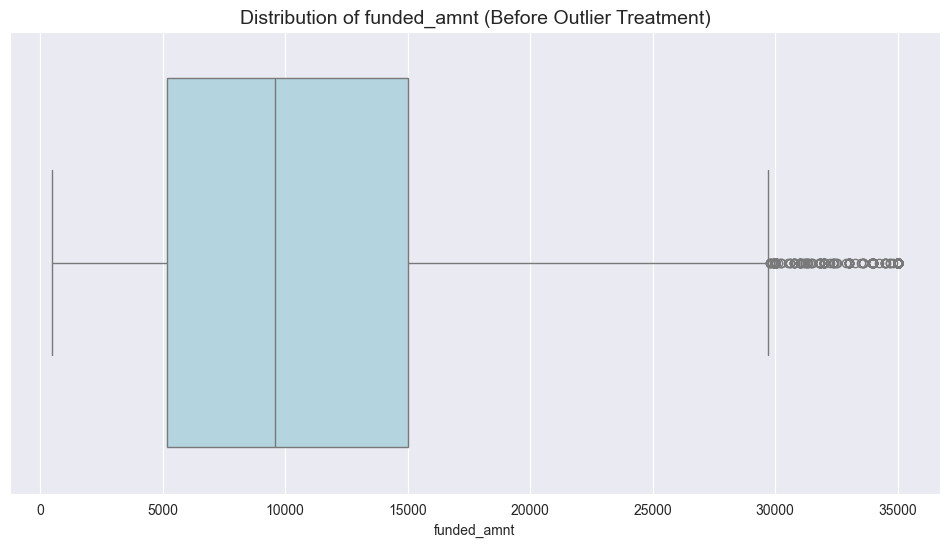

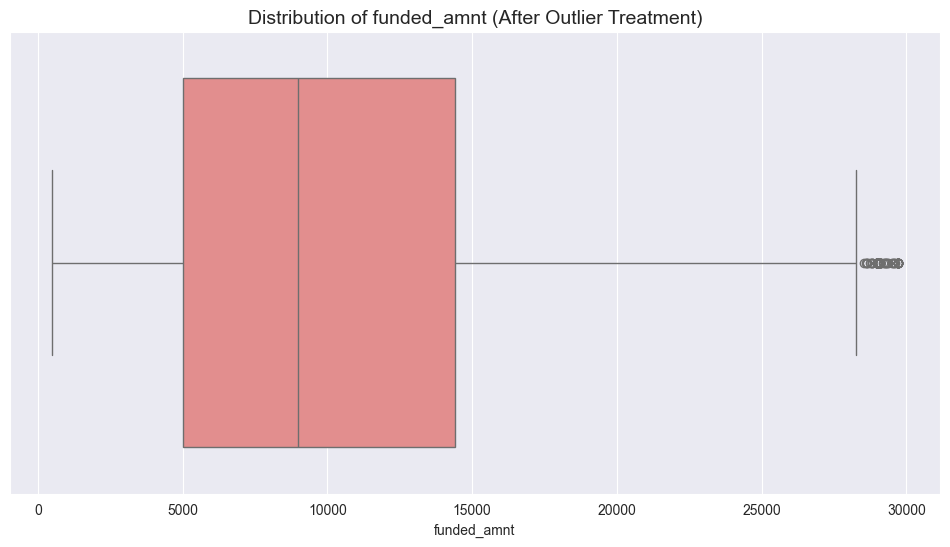

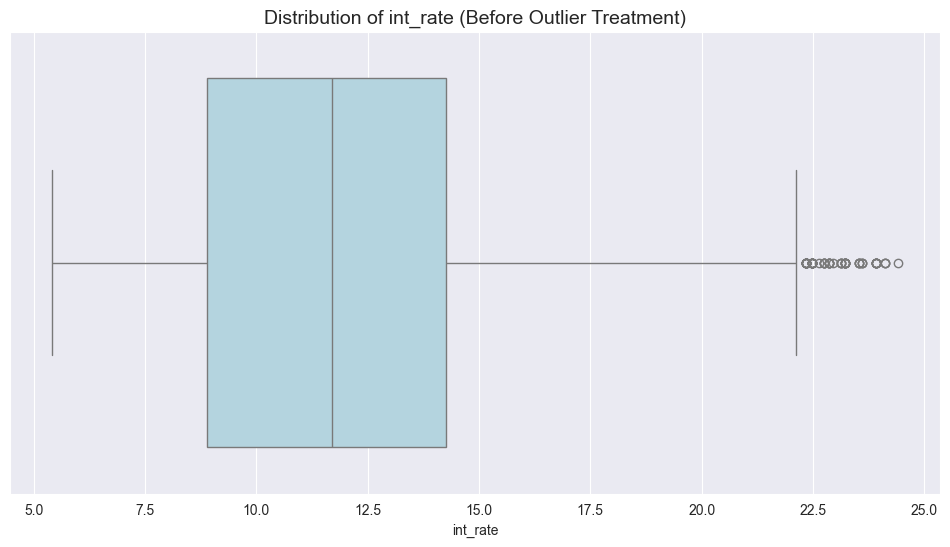

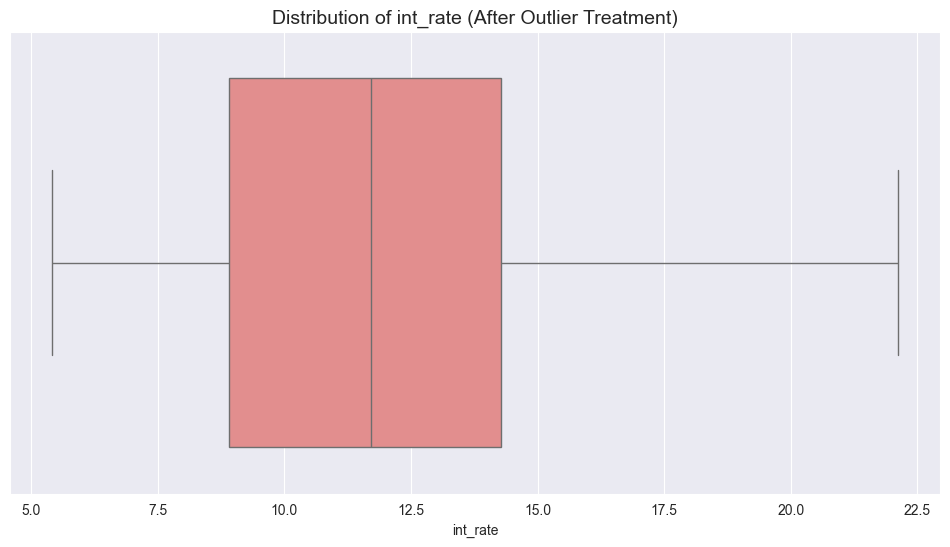

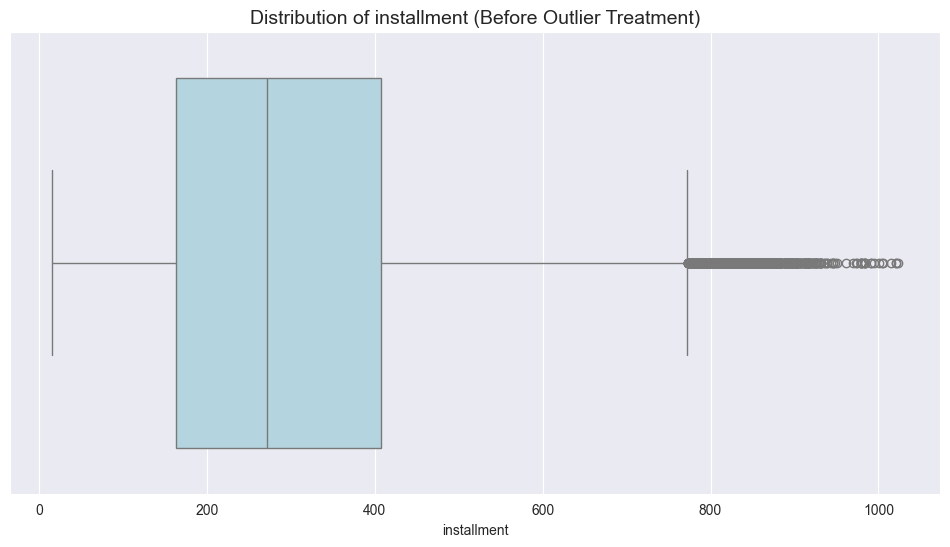

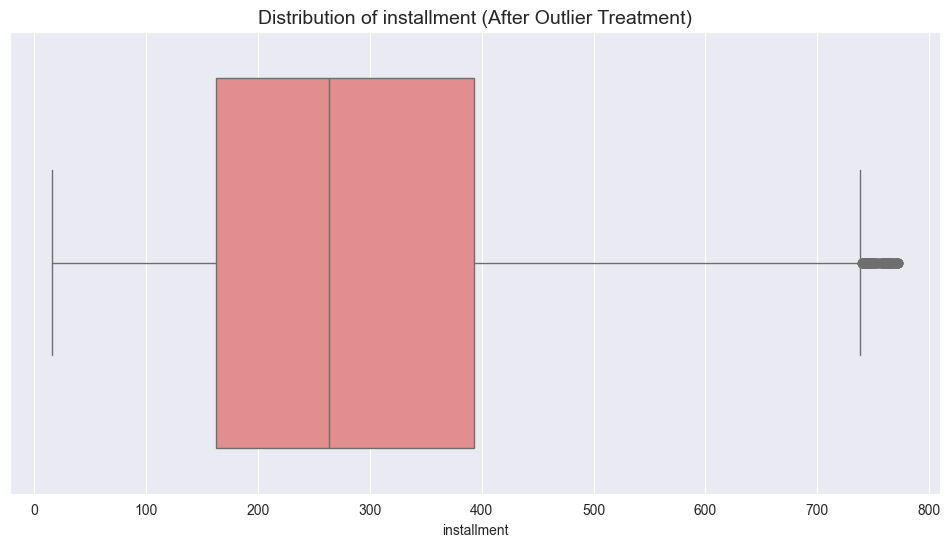

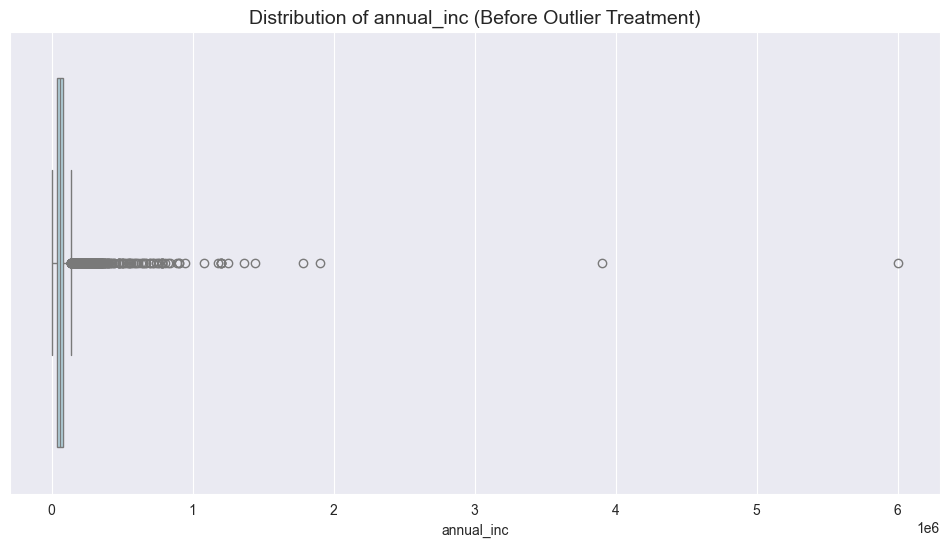

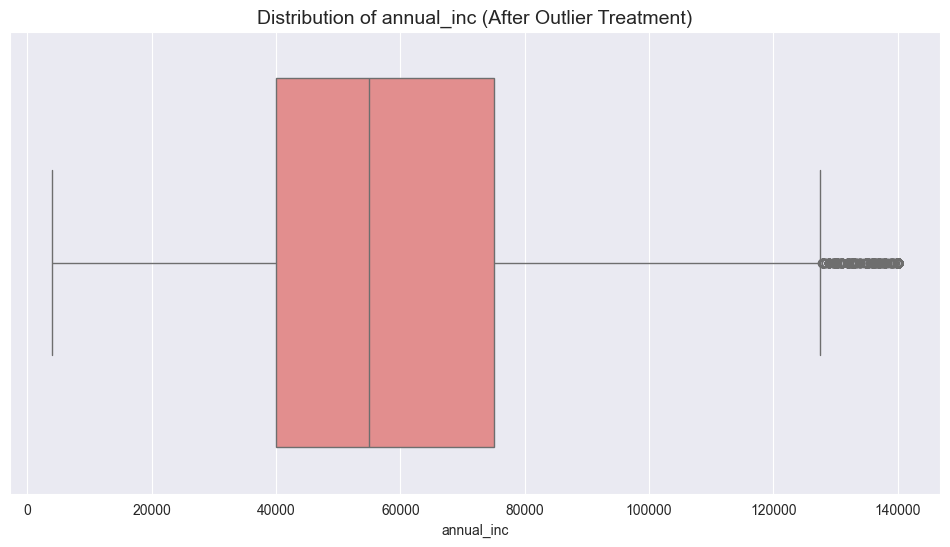

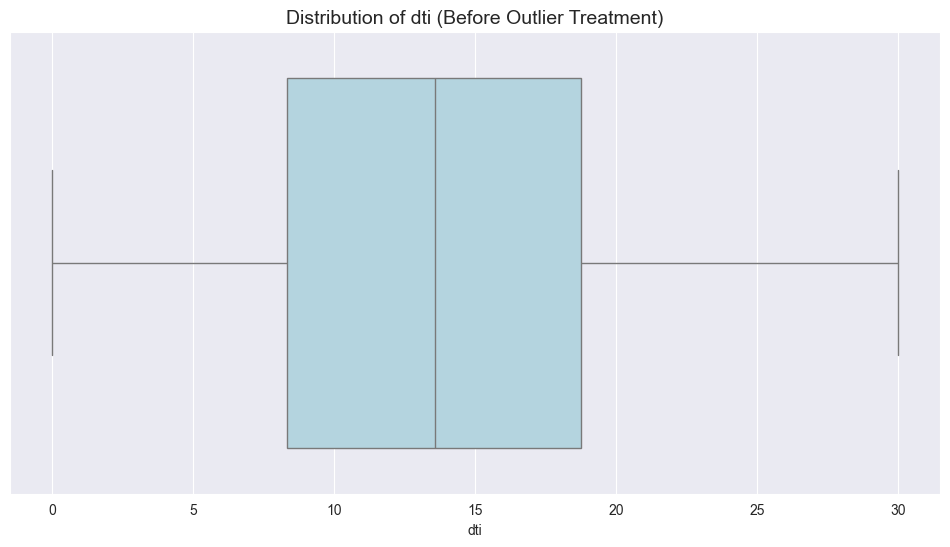

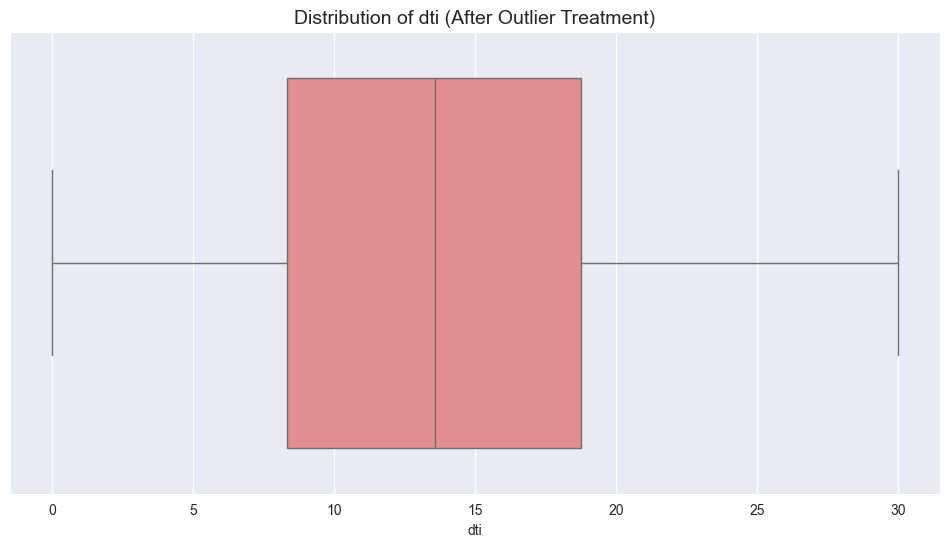

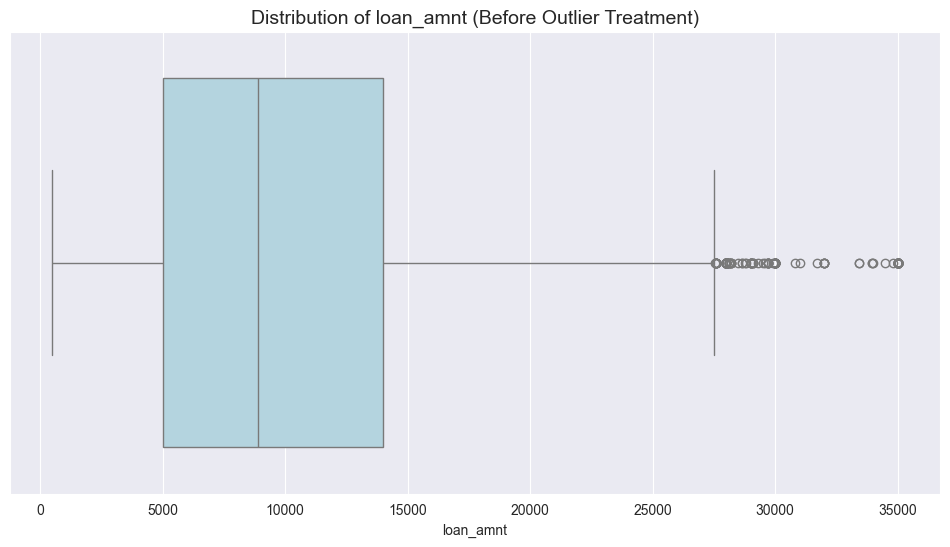

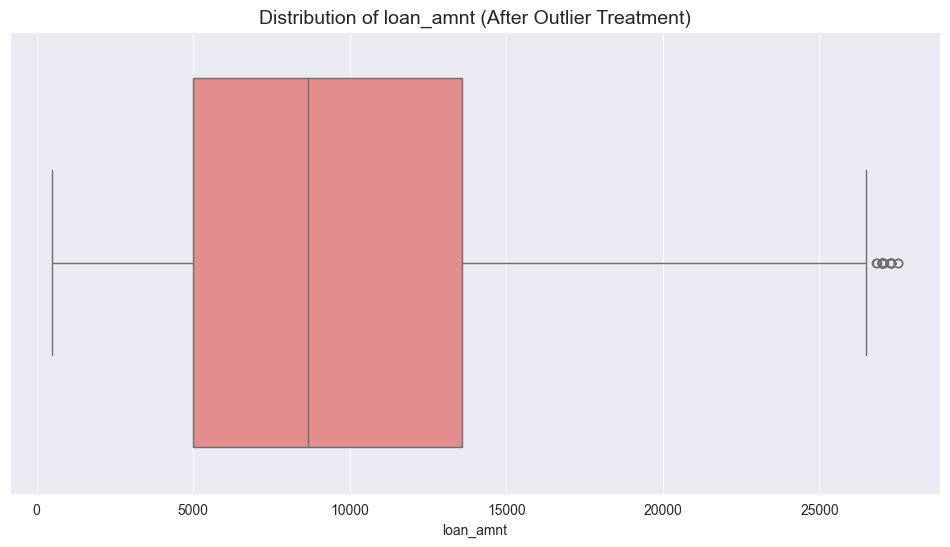

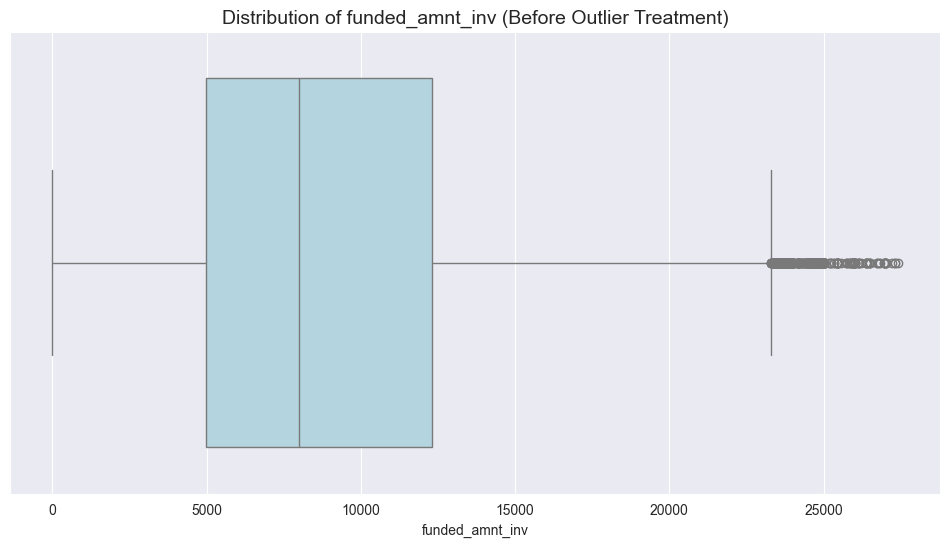

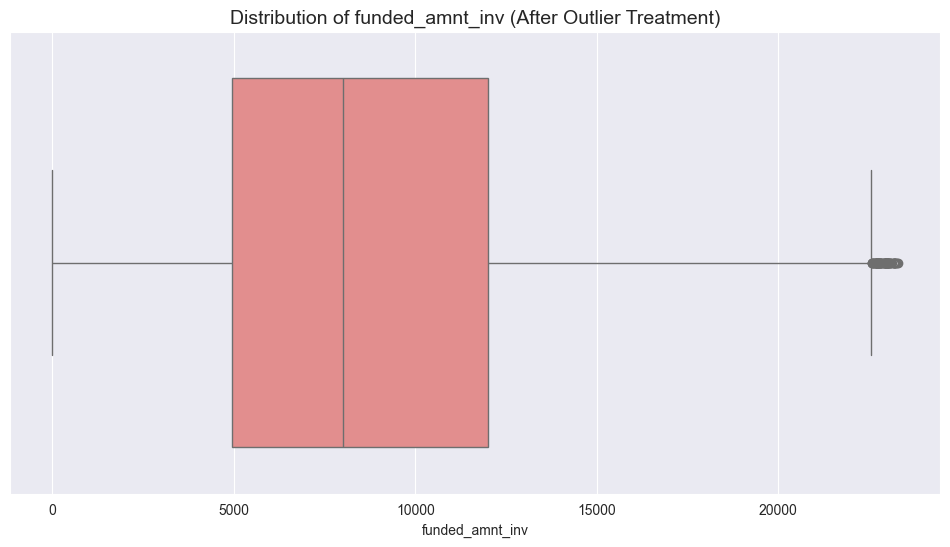

(33566, 29)

In [29]:
# we will follow the general way of dealing with Outliers which is using The IQR Method.

# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# List of columns for outlier treatment
outlier_treatment = ['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'loan_amnt', 'funded_amnt_inv']

# Univariate analysis before and after outlier treatment
for col in outlier_treatment:
    
    # Univariate analysis before outlier treatment (color: blue)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_loan[col], color='lightblue') 
    plt.title(f'Distribution of {col} (Before Outlier Treatment)', fontsize=14)
    plt.show()

    # Removing outliers directly in the dataset
    df_loan = remove_outliers(df_loan, col)
    
    # Univariate analysis after outlier treatment (color: orange)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_loan[col], color='lightcoral')
    plt.title(f'Distribution of {col} (After Outlier Treatment)', fontsize=14)
    plt.show()

df_loan.shape


In [30]:
df_loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,year_of_issue,month_of_issue,issue_q,funded_amnt_inv_b,loan_amnt_b,funded_amnt_b,annual_inc_b,int_rate_category,dti_category
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Below Average,Severe
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,0.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Negligible
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Mild
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,10.0,...,0.0,2011,12,Q4,10K - 20K,10K - 20K,10K - 20K,40k - 50k,Above Average,Elevated
5,1075269,5000,5000,5000.0,36,7.90,156.46,A,A4,3.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Minimal,Mild


<h2> Univariate Analysis </h2>
<h4> Now we have outliers removed from that dataset, we can start gathering insights from each column and what impact columns have.</h4>
<h4> A) UnOrdered variable Analysis </h4>
<h4> B) ordered Categorical Variable Analysis </h4>
<h4> C) Quantitive Categorical Variable Analysis </h4>
<h4> D) Derived Variable Analysis </h4>

<h2> Unordered Categorical Variable Analysis </h2>

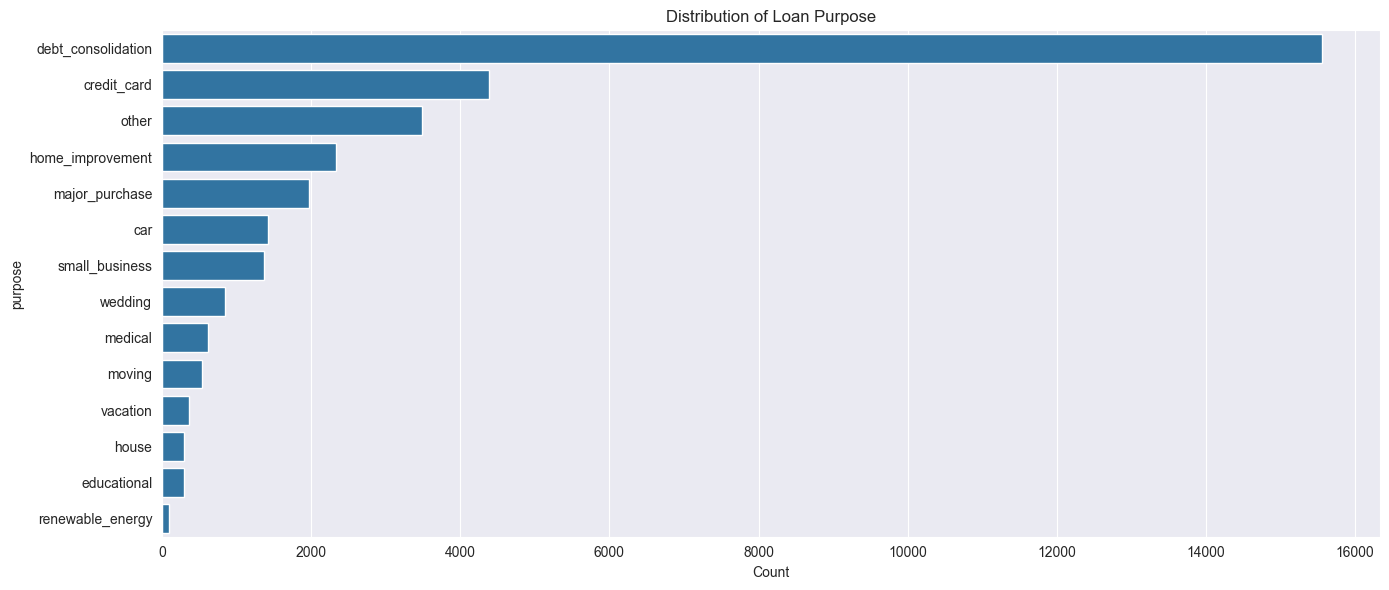

In [31]:
def plot_column_distribution(data, column, title, figsize=(14, 6), xlabel='Count', ylabel=None):
    plt.figure(figsize=figsize)
    sns.countplot(data=data, y=column, order=data[column].value_counts().index)
    plt.title(title)
    plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

#'purpose' column
plot_column_distribution(data=df_loan, 
                         column='purpose', 
                         title='Distribution of Loan Purpose')

The majority of loans are for debt consolidation, followed by credit card repayment. Categories like renewable energy have significantly lower counts, showing less demand in those areas.

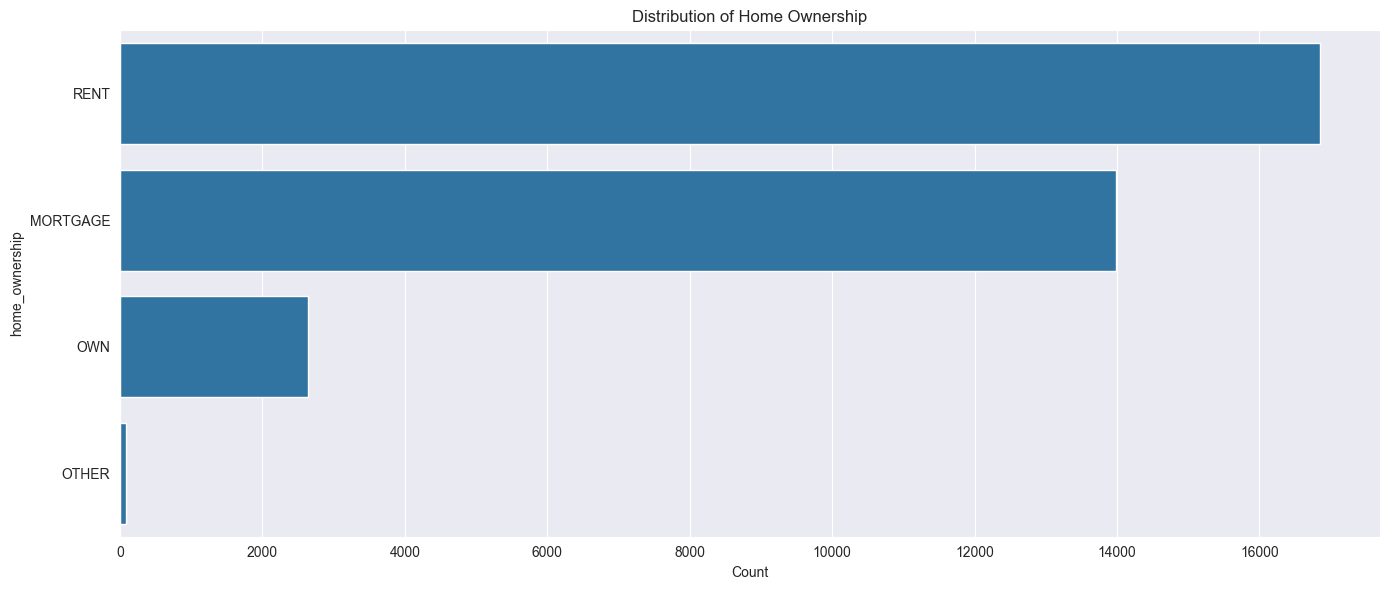

In [32]:
#'home_ownership' column
plot_column_distribution(data=df_loan, 
                         column='home_ownership', 
                         title='Distribution of Home Ownership')

Most applicants either rent or have a mortgage, indicating they are not fully independent property owners. There is a very small proportion of loans for those who own homes outright.

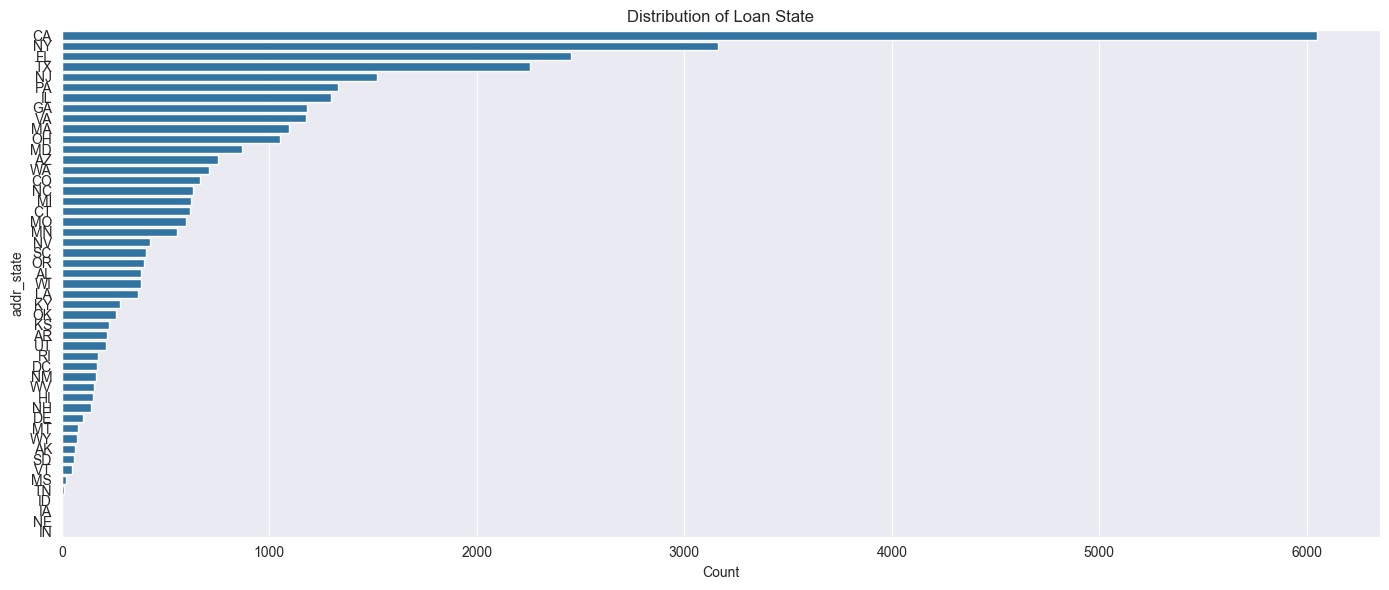

In [33]:
# 'addr_state' column
plot_column_distribution(data=df_loan, 
                         column='addr_state', 
                         title='Distribution of Loan State')

California (CA) leads in the number of loans, followed by other states like New York (NY) and Florida (FL). Some states show significantly lower volumes, which could be due to either lower demand or stricter lending policies.

<h2> Ordered Categorical Variable Analysis </h2>

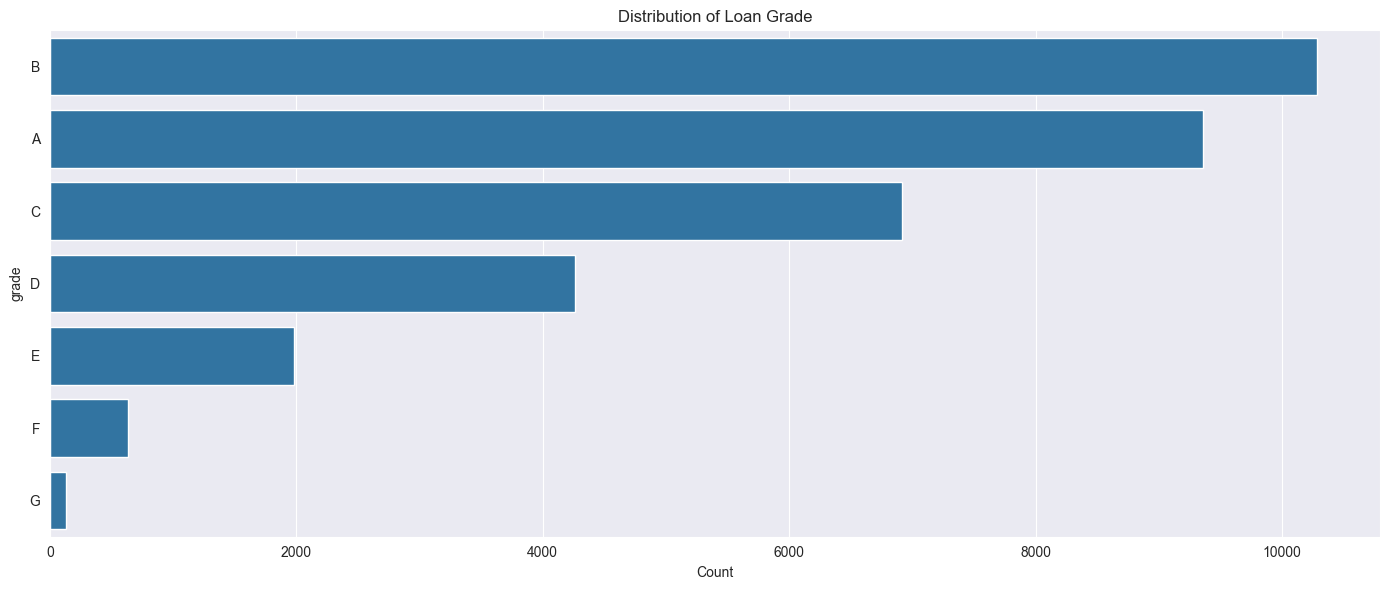

In [34]:
# #'grade' column
plot_column_distribution(data=df_loan, 
                         column='grade', 
                         title='Distribution of Loan Grade')

Grade B has the highest number of loans, followed closely by Grade A. Grades E, F, and G represent fewer loans, indicating more stringent criteria or lower demand for these higher-risk grades.

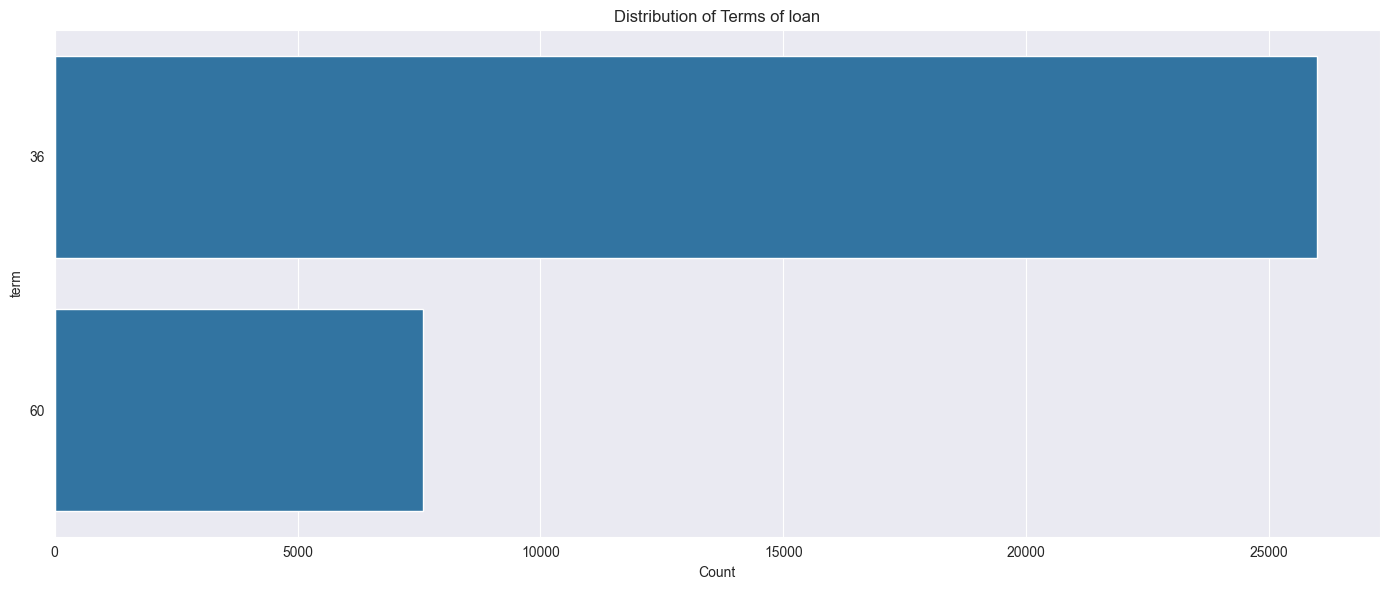

In [35]:
# 'Term' columns
plot_column_distribution(data=df_loan, 
                         column='term', 
                         title='Distribution of Terms of loan')

Majority of the loan applications counts are in the term of 36 months.

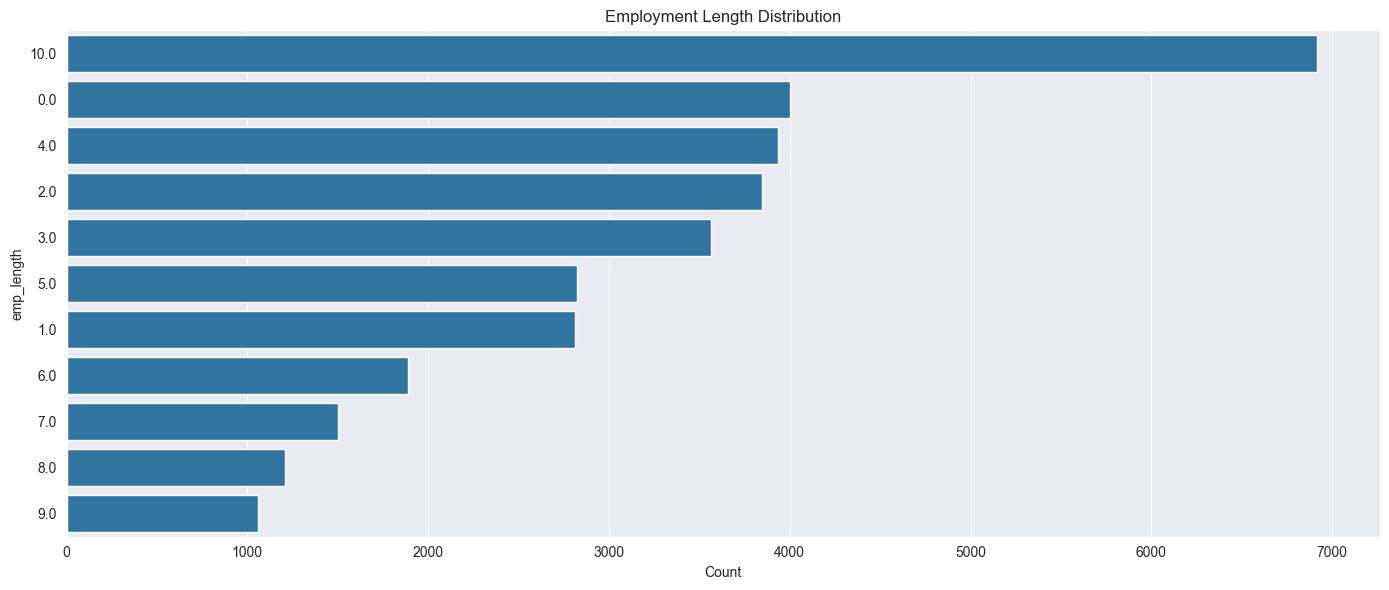

In [36]:
# 'emp_length' column
plot_column_distribution(data=df_loan, 
                         column='emp_length', 
                         title='Employment Length Distribution')

The majority of borrowers have been employed for over 10 years, indicating a relatively stable employment background for most applicants. Shorter employment periods, such as less than a year, have much lower loan applications, suggesting higher risk aversion for newer employees.

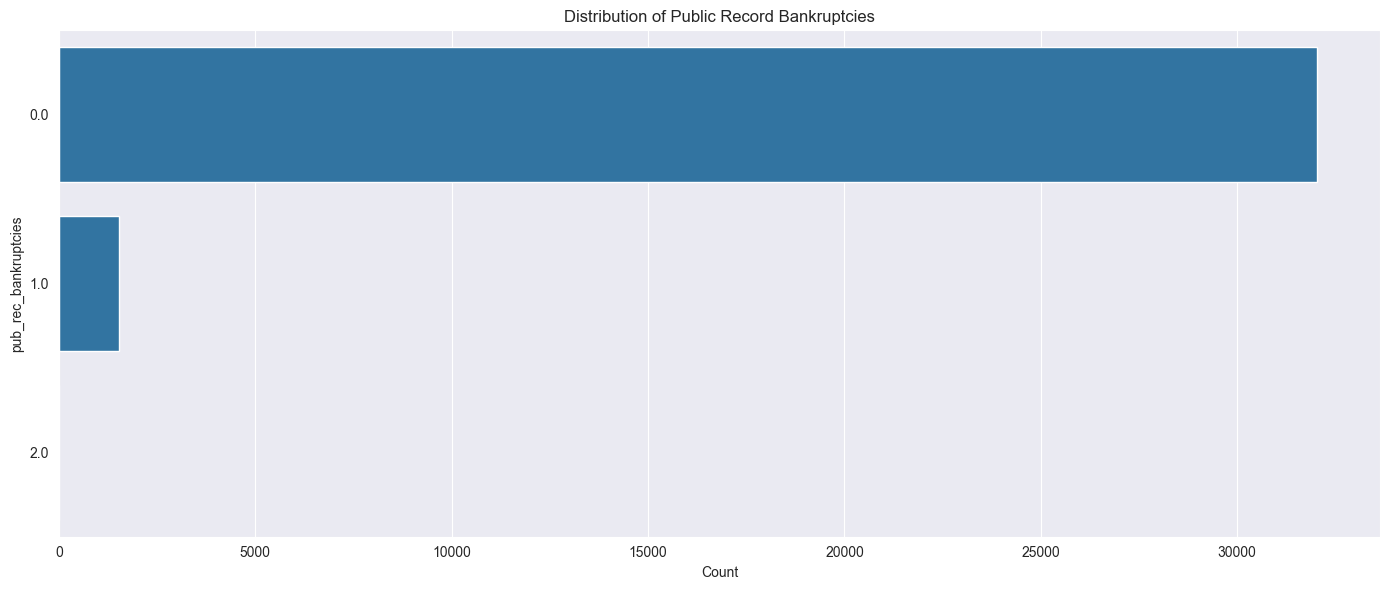

In [37]:
# "pub_rec_bankruptcies" column
plot_column_distribution(data=df_loan, 
                         column='pub_rec_bankruptcies', 
                         title='Distribution of Public Record Bankruptcies')

The majority of borrowers have no public record bankruptcies (0), which suggests that most applicants have a clean credit history. There are a small number of applicants who have 1 or more bankruptcies, which may indicate a higher risk of default for those individuals.

In [38]:
# Function to perform univariate analysis with a histogram and boxplot
def analyze_variable(df, column, title_dict=None):
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))

    # Violin Plot
    sns.violinplot(x=df[column].dropna(), ax=axes[0], color='lightgreen')
    axes[0].set_title(f'Violin Plot for {column}')
      
    # Rug Plot + KDE
    sns.kdeplot(df[column].dropna(), ax=axes[1], color='darkblue')
    sns.rugplot(df[column].dropna(), ax=axes[1], color='black')
    axes[1].set_title(f'KDE with Rug for {column}')

    # Custom labels if provided
    if title_dict and column in title_dict:
        for i in range(2):
            axes[i].set_xlabel(title_dict[column])

    plt.tight_layout()
    plt.show()

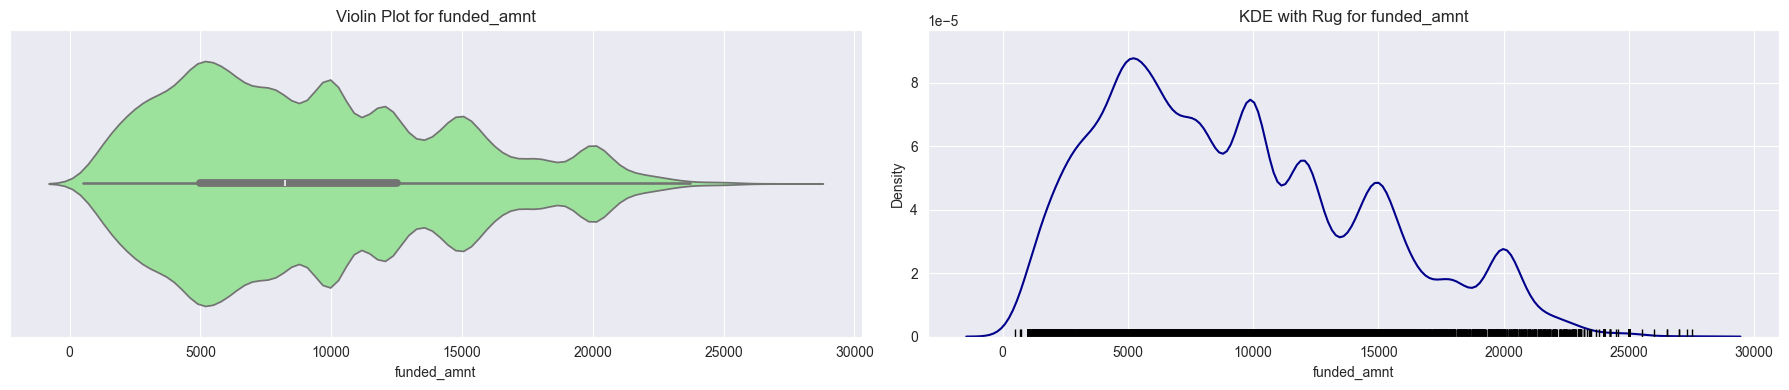

In [39]:
analyze_variable(df_loan, 'funded_amnt')

1. Violin Plot:
The majority of the funded_amnt values are concentrated between 5,000 and 20,000.
The distribution shows a median around 10,000, with some loans extending up to 30,000.
2. KDE Plot with Rug Plot:
The KDE plot shows multiple peaks, indicating that the distribution is multimodal, with most loans falling between 5,000 and 15,000.
The rug plot confirms that there are fewer loans with amounts greater than 25,000.

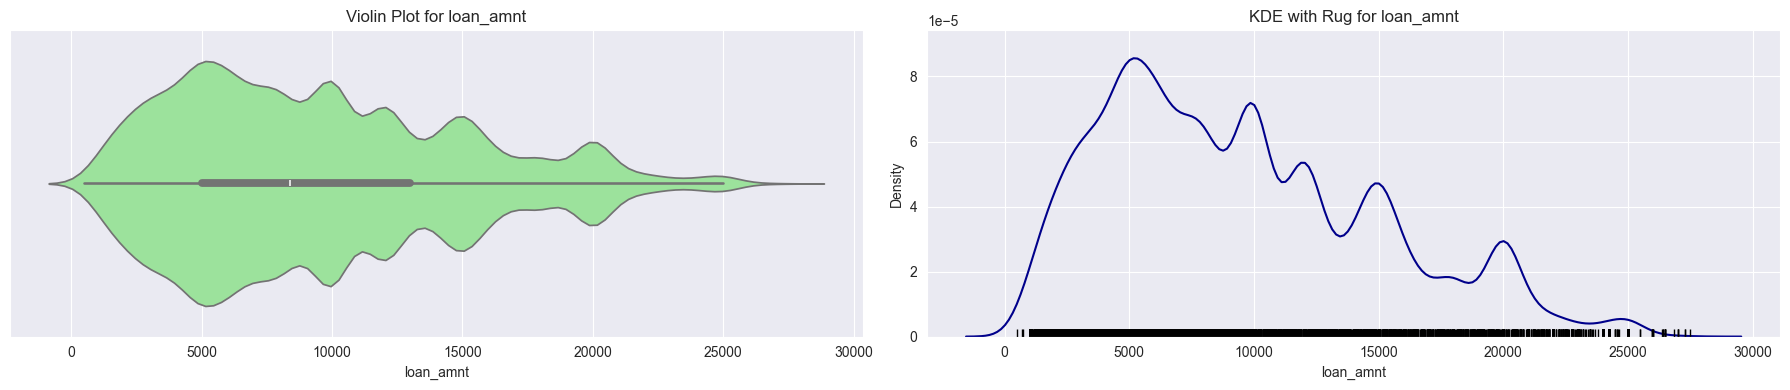

In [40]:
analyze_variable(df_loan, 'loan_amnt')

1. Violin Plot:
The majority of the loan_amnt values fall between 5,000 and 15,000.
The distribution shows a median around 10,000, with few loans exceeding 25,000.
2. KDE Plot with Rug Plot:
The KDE plot shows multiple peaks, indicating a multimodal distribution, with most loans concentrated between 5,000 and 15,000.
The rug plot shows that there are fewer loans with amounts exceeding 20,000, confirming the tapering distribution.

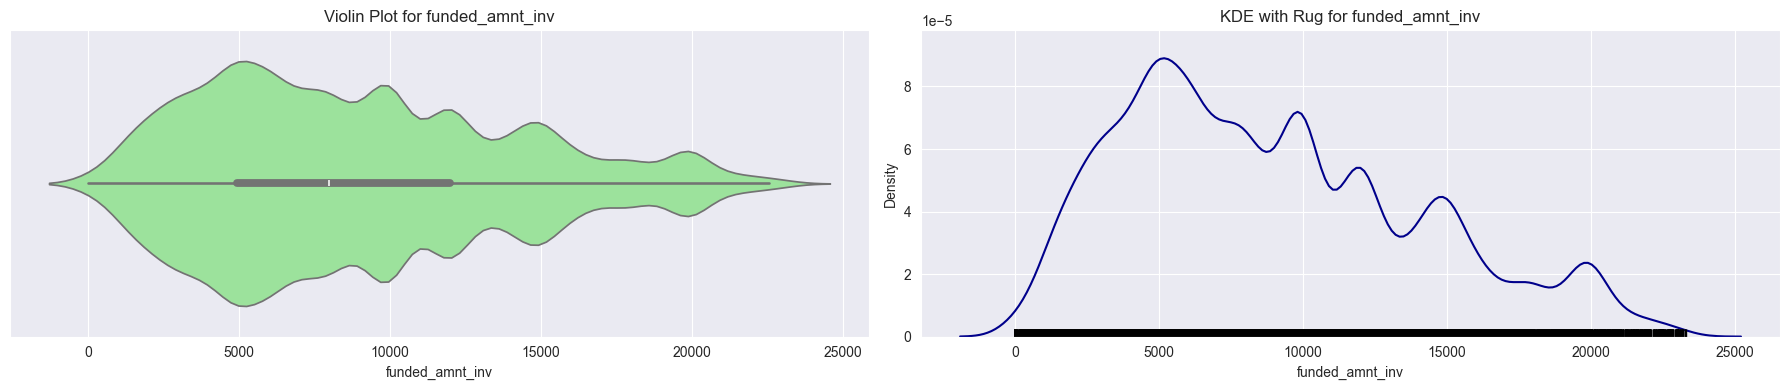

In [41]:
analyze_variable(df_loan, 'funded_amnt_inv')


1. Violin Plot:
The majority of the funded_amnt_inv values are concentrated between 5,000 and 15,000.
The median is around 10,000, with a few loans extending up to 25,000.
2. KDE Plot with Rug Plot:
The KDE plot indicates multiple peaks, suggesting a multimodal distribution between 5,000 and 15,000.
The rug plot confirms that there are fewer loans with amounts above 20,000.

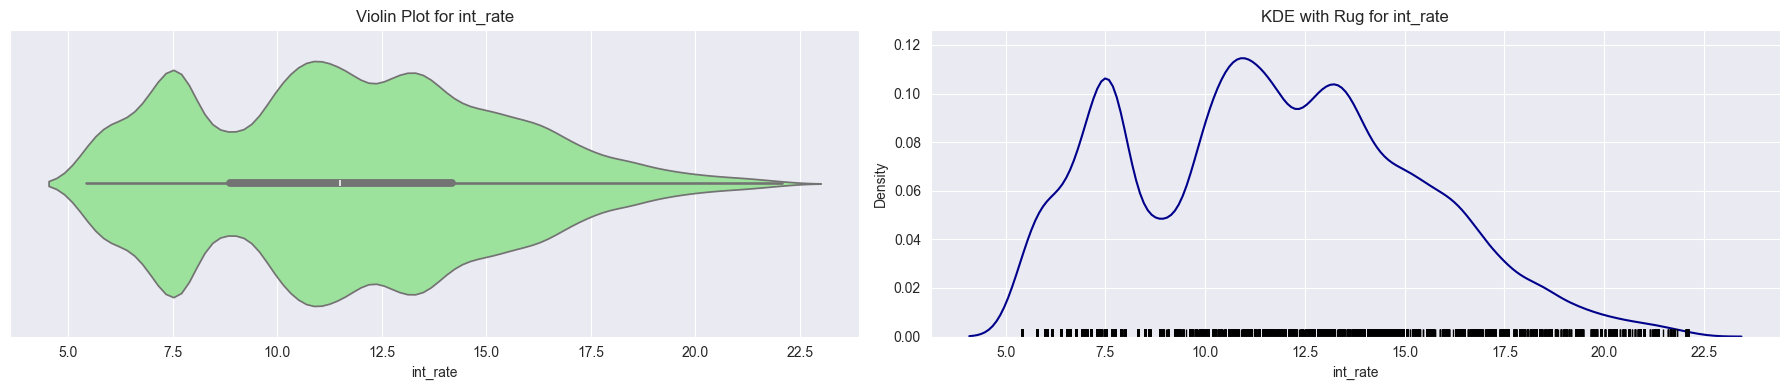

In [42]:
analyze_variable(df_loan, 'int_rate')


1. Violin Plot:
The majority of the int_rate values are concentrated between 7.5% and 15%, with the median around 10%.
There is a gradual tapering at higher interest rates, with some loans having rates as high as 22.5%.
2. KDE Plot with Rug Plot:
The KDE plot shows multiple peaks, indicating a multimodal distribution, with the highest density of loans occurring between 7.5% and 12%.
The rug plot highlights the presence of fewer loans with interest rates higher than 20%.

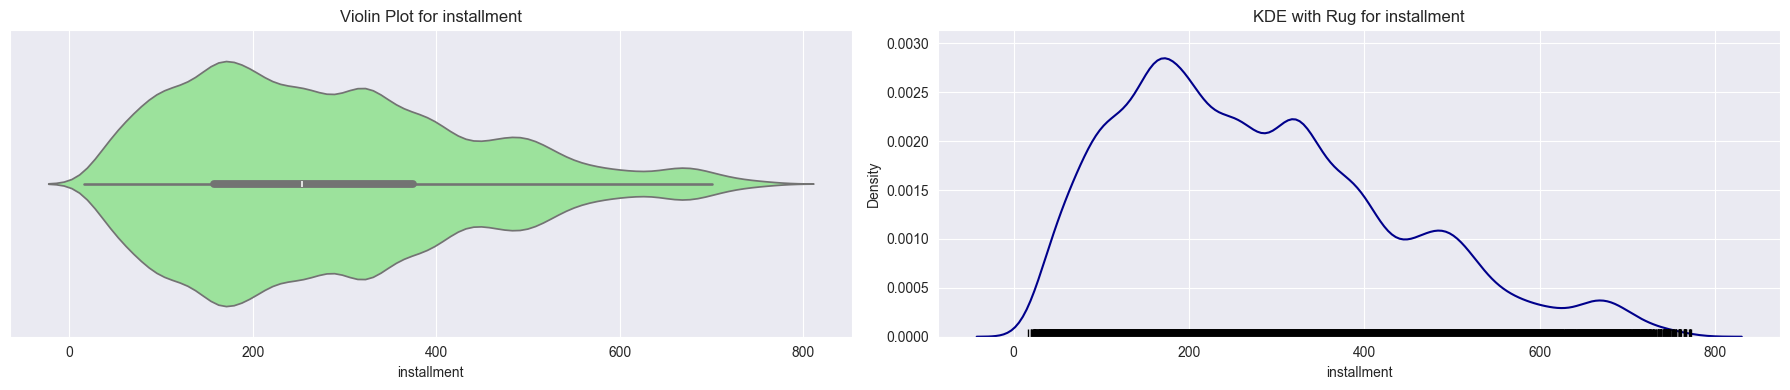

In [43]:
analyze_variable(df_loan, 'installment')

1. Violin Plot:
The installment values are mostly concentrated between 200 and 500, with the median close to 350.
There are fewer loans with high installment amounts, extending up to around 850.
2. KDE Plot with Rug Plot:
The KDE plot shows a right-skewed distribution, with most loans having installments between 200 and 400.
The rug plot highlights that higher installment values (above 600) are relatively rare.

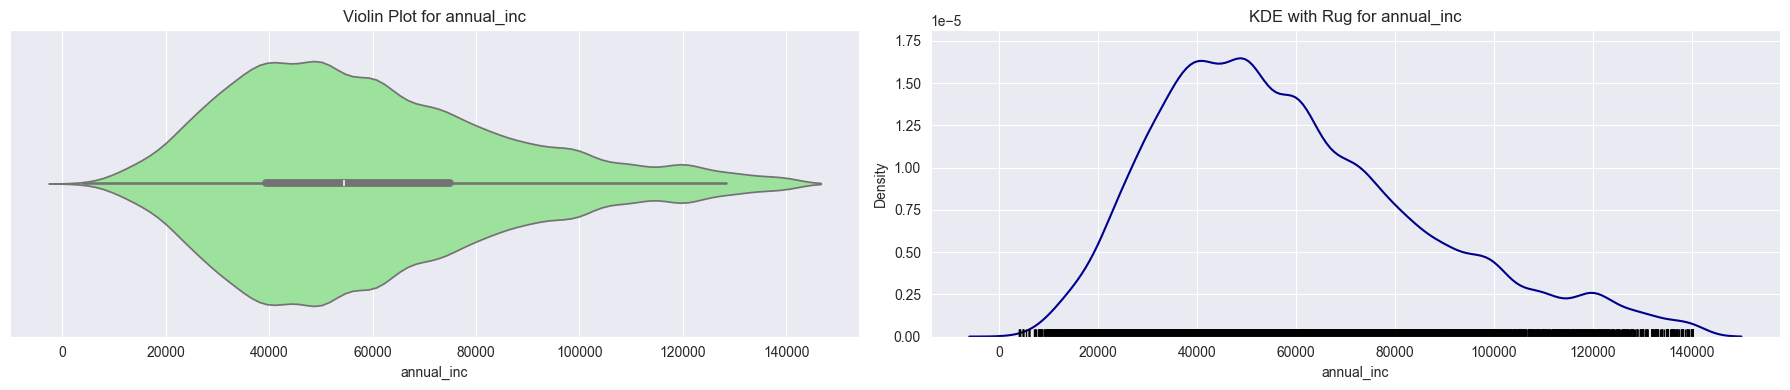

In [44]:
analyze_variable(df_loan, 'annual_inc')

1. Violin Plot:
The annual_inc values are primarily concentrated between 40,000 and 80,000, with the median close to 60,000.
There are a few high-income outliers, extending beyond 140,000, but these are relatively rare.
2. KDE Plot with Rug Plot:
The KDE plot shows a right-skewed distribution, with most incomes clustering between 40,000 and 80,000.
The rug plot indicates fewer individuals with annual incomes greater than 100,000.

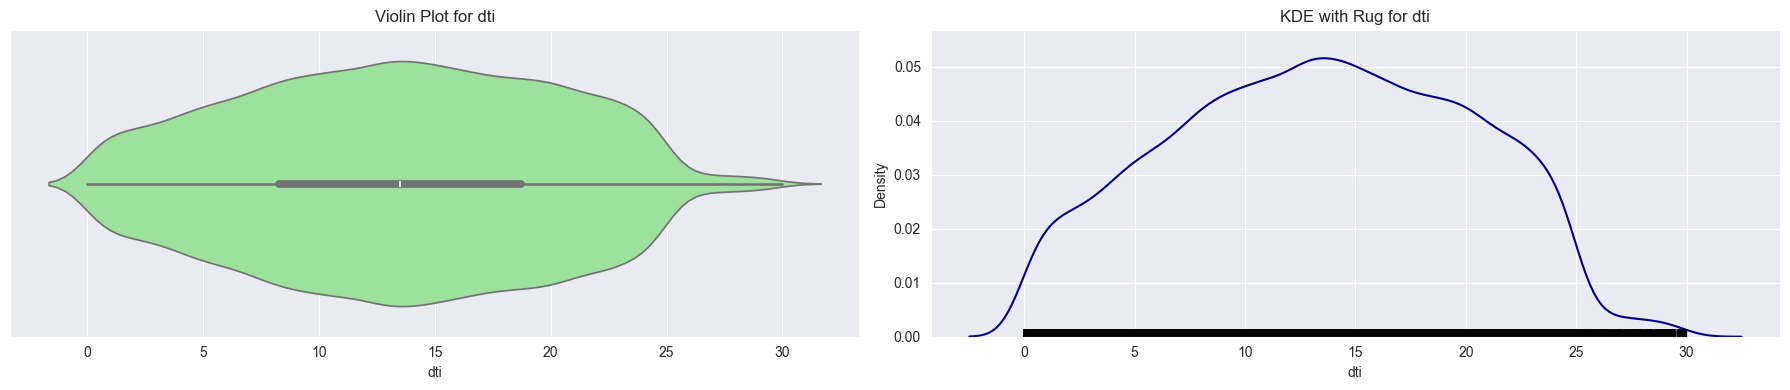

In [45]:
analyze_variable(df_loan, 'dti')


1. Violin Plot:
The dti (debt-to-income ratio) values are mostly concentrated between 10 and 20, with the median around 15.
There are some outliers with higher values, but the majority fall below 30.
2. KDE Plot with Rug Plot:
The KDE plot shows a unimodal distribution, peaking around a dti of 15, with a gradual decline beyond 20.
The rug plot indicates that values above 25 are rare in the dataset.

## Derived Variable Analysis

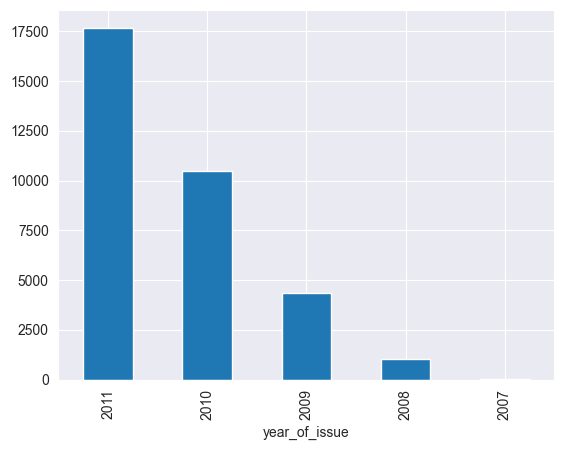

In [46]:
df_loan['year_of_issue'].value_counts().plot.bar()
plt.show()

The highest number of loans were issued in 2011, likely reflecting the aftermath of the Great Recession as individuals and businesses sought financial recovery.
Loan issuance decreased significantly in the earlier years, with the lowest number in 2007, reflecting the financial stability prior to the crisis.

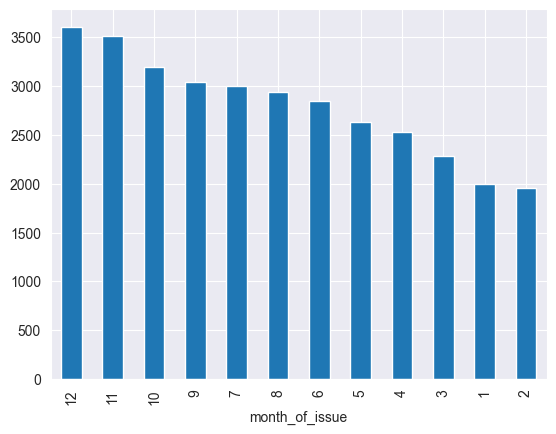

In [47]:
df_loan['month_of_issue'].value_counts().plot.bar()
plt.show()

The number of loans issued is highest in December and November, indicating a potential increase in loan demand during the holiday season.
There is a gradual decline in loan issuances from mid-year onwards, with the lowest numbers in February, possibly reflecting a seasonal trend.

In [48]:
df_loan.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,year_of_issue,month_of_issue,issue_q,funded_amnt_inv_b,loan_amnt_b,funded_amnt_b,annual_inc_b,int_rate_category,dti_category
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Below Average,Severe
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,0.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Negligible
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,10.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Significant,Mild
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,10.0,...,0.0,2011,12,Q4,10K - 20K,10K - 20K,10K - 20K,40k - 50k,Above Average,Elevated
5,1075269,5000,5000,5000.0,36,7.90,156.46,A,A4,3.0,...,0.0,2011,12,Q4,0 - 10K,0 - 10K,0 - 10K,0 - 40k,Minimal,Mild


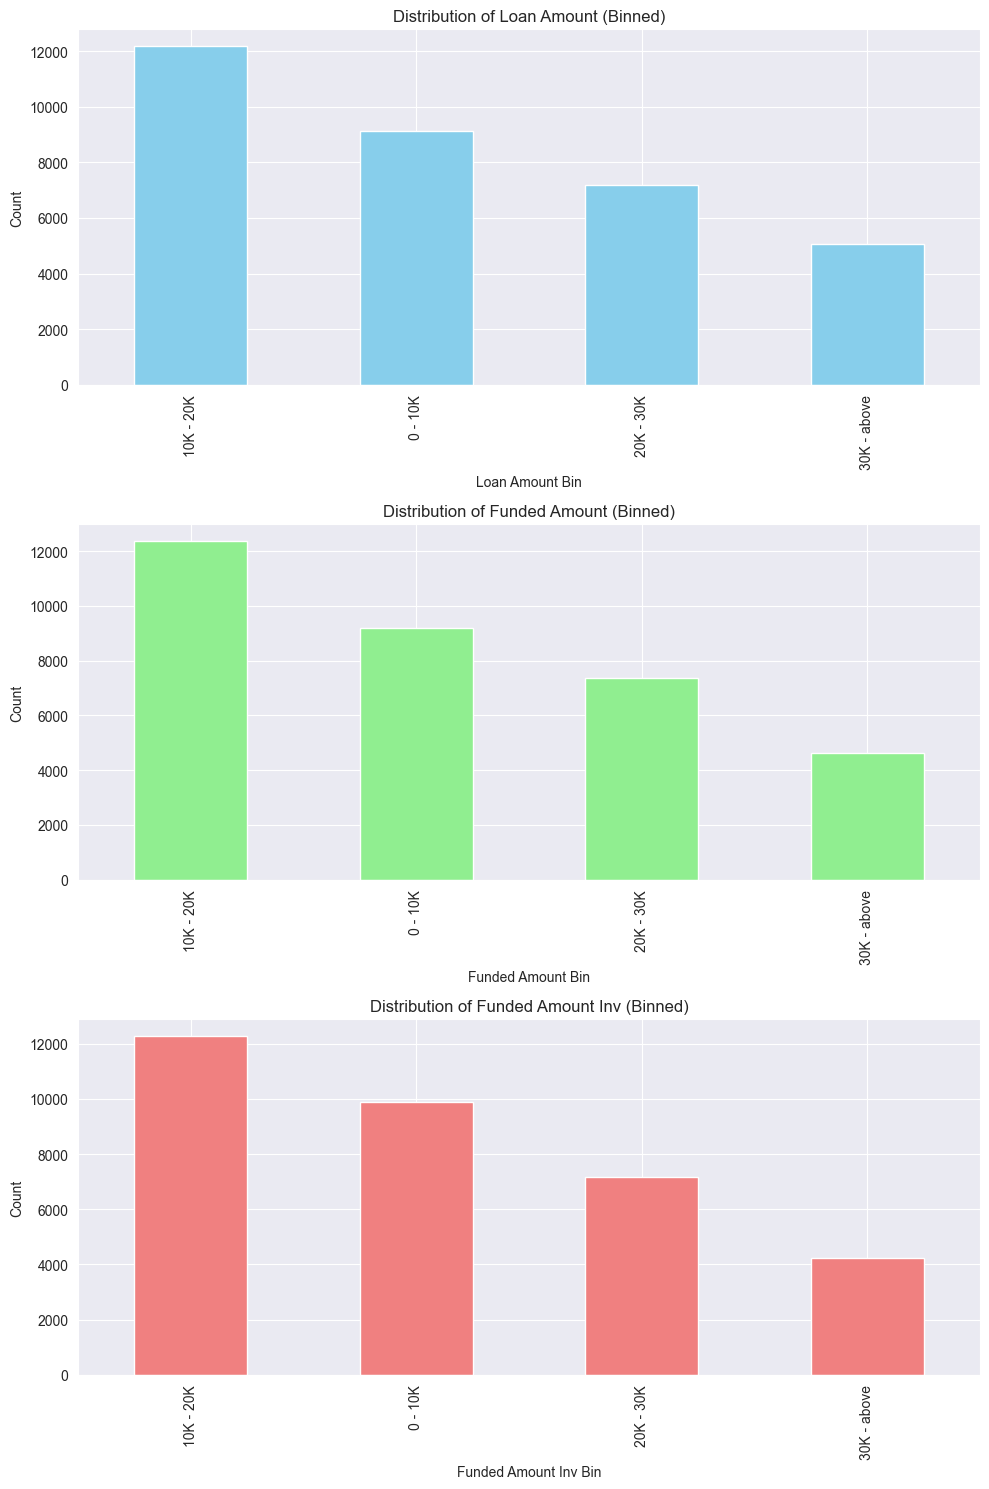

In [49]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for loan_amnt_b
df_loan['loan_amnt_b'].value_counts().plot.bar(ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Loan Amount (Binned)')
axes[0].set_xlabel('Loan Amount Bin')
axes[0].set_ylabel('Count')

# Plot for funded_amnt_b
df_loan['funded_amnt_b'].value_counts().plot.bar(ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Funded Amount (Binned)')
axes[1].set_xlabel('Funded Amount Bin')
axes[1].set_ylabel('Count')

# Plot for funded_amnt_inv_b
df_loan['funded_amnt_inv_b'].value_counts().plot.bar(ax=axes[2], color='lightcoral')
axes[2].set_title('Distribution of Funded Amount Inv (Binned)')
axes[2].set_xlabel('Funded Amount Inv Bin')
axes[2].set_ylabel('Count')

# Show plots
plt.tight_layout()
plt.show()

10K-20K Range: This range shows the highest count in all plots, indicating that the majority of loans fall within this amount range.
0-10K Range: This range also has a significant number of loans, showing that smaller loan amounts are relatively common.
30K and Above: All three plots show that loans in the highest category (30K and above) are the least frequent, suggesting that larger loans are less common overall.

<Axes: xlabel='dti_category'>

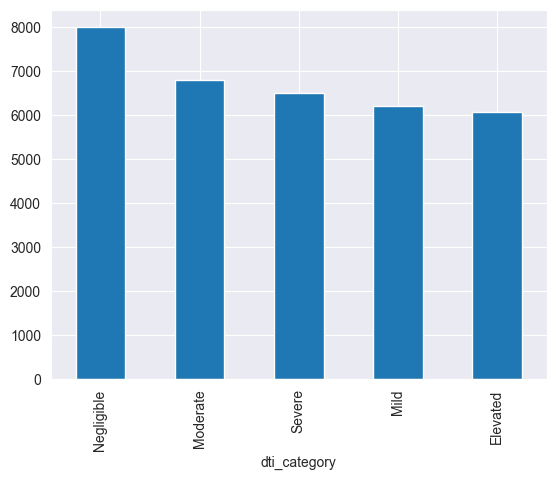

In [50]:
df_loan['dti_category'].value_counts().plot.bar()

The Negligible debt-to-income (DTI) category has the highest number of entries, indicating that many borrowers have low DTI ratios.
There is a fairly balanced distribution across Moderate, Severe, Mild, and Elevated categories, with no extreme skewness towards any single category beyond Negligible.

<Axes: xlabel='int_rate_category'>

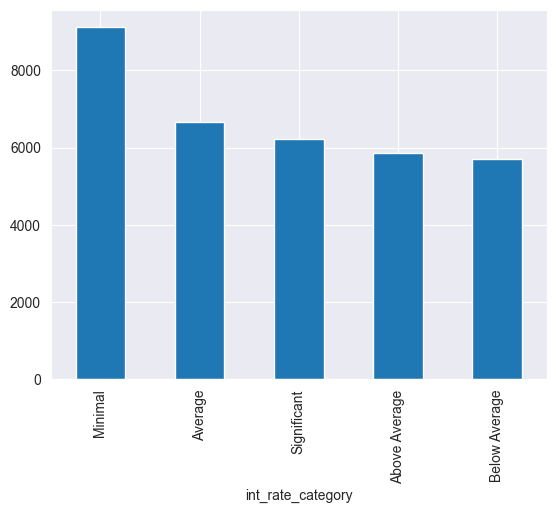

In [51]:
df_loan['int_rate_category'].value_counts().plot.bar()

The Minimal interest rate category has the highest count, indicating that many borrowers secured loans with lower interest rates.
The distribution across other categories like Average, Significant, and Above Average is relatively even, suggesting a balanced spread of interest rates for the remaining loans.

<Axes: xlabel='annual_inc_b'>

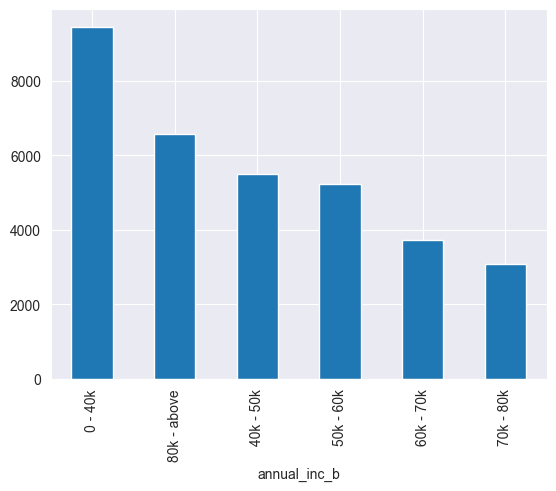

In [52]:
df_loan['annual_inc_b'].value_counts().plot.bar()

<h3> Summary (Univariate Analysis) </h3>

<h4> Applicant Characteristics </h4>

- A large portion of applicants have an annual income within the 0-40K range.  
- Most applicants have a debt-to-income ratio that ranges from 0 to 20, with a maximum observed value of 30.  
- The majority of applicants are either renting or have a mortgage on their home.  
- Debt consolidation is the primary reason for loan applications.  
- California (CA) stands out as the state with the highest number of loan requests.  
- Most applicants do not have a history of public bankruptcy records.  
- The largest group of applicants has been employed for 10+ years, with a significant portion having between 0-2 years of experience.  

<h4> Loan Details </h4>

- Loan amounts typically fall between 10K and 20k.  
- The majority of applicants have interest rates ranging from 5% to 16%, with the maximum reaching 22%.  
- Most installment amounts are between $20 and $400.  
- Most loan terms are 36 months in duration.  
- The majority of applicants are classified under Grade B.  

<h4> Time Trends </h4>

- The volume of loan applications has increased steadily year over year.  
- Quarter 4 consistently sees the highest volume of loan applications.  
- Quarter 1 tends to have the lowest loan application volume.  
    - This could be due to year-end financial difficulties.  
    - This may also be linked to holiday spending and debt consolidation.  

<h4> Insights </h4>

- The applicant data shows which segments are most likely to apply for loans, giving insight into potential target markets for increasing loan volume.  
- Additional analysis is needed to understand why certain segments have lower loan application rates.  
- LendingClub should anticipate higher loan application volumes in Quarter 4.  
- There is an opportunity for LendingClub to target applicants more effectively in the first three quarters to boost overall volume.  


<h2> Bivariate Analysis </h2>

In [53]:
# Now we will compare loan status column to every relevant columns which can have effect/affect on it.

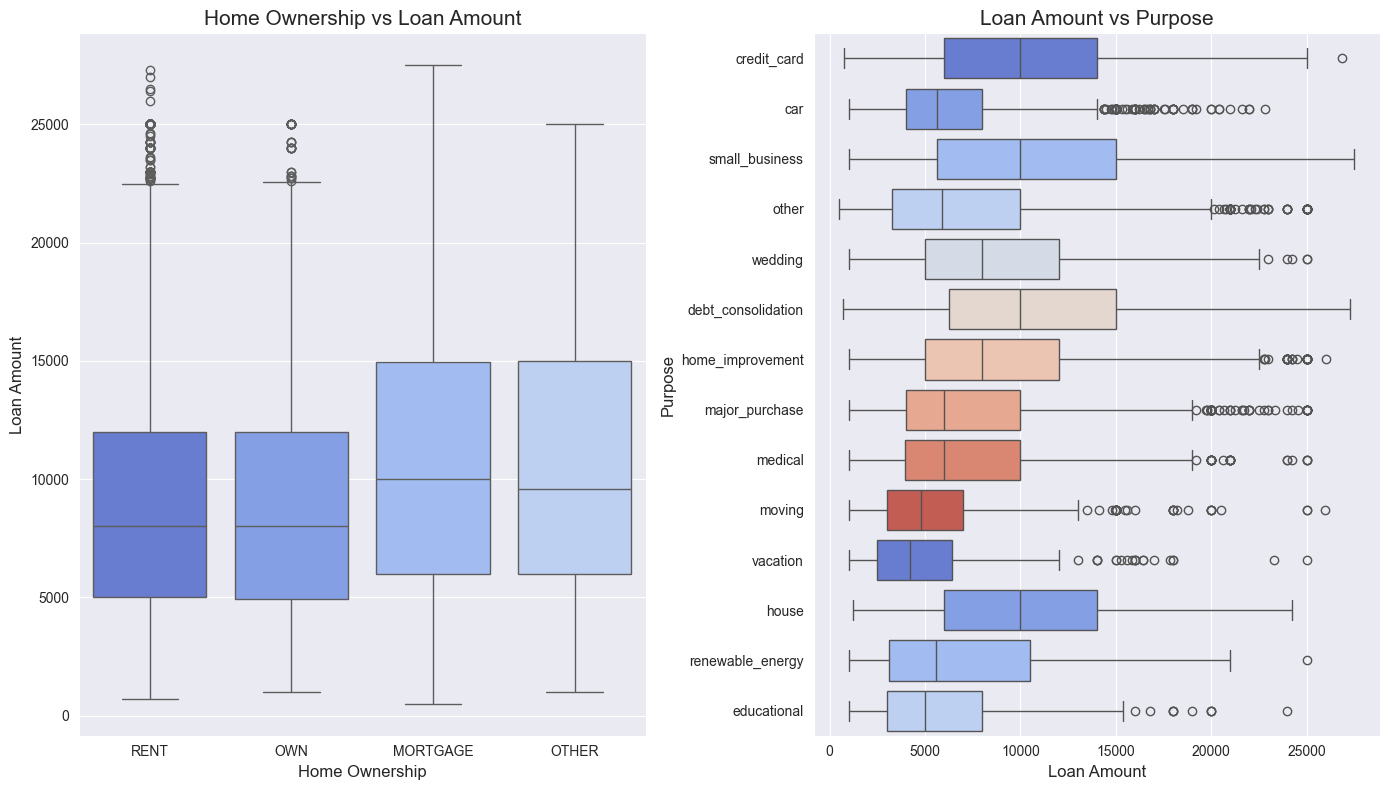

In [54]:
palette = sns.color_palette("coolwarm", 10)

plt.figure(figsize=(14, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x="home_ownership", y="loan_amnt", data=df_loan, palette=palette)
plt.title("Home Ownership vs Loan Amount", fontsize=15)
plt.xlabel("Home Ownership", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(y="purpose", x="loan_amnt", data=df_loan, palette=palette)
plt.title("Loan Amount vs Purpose", fontsize=15)
plt.xlabel("Loan Amount", fontsize=12)
plt.ylabel("Purpose", fontsize=12)

plt.tight_layout()
plt.show()

### Insights:

1. **Home Ownership vs Loan Amount**:
   - Borrowers with mortgages apply for higher loan amounts (~15k USD), while renters and homeowners apply for smaller loans (~10k USD).
   - Outliers exist in all categories for larger loans.

2. **Loan Amount vs Purpose**:
   - Debt consolidation and credit card loans see the highest amounts (~15k USD).
   - Categories like vacations and educational loans have much smaller amounts (~5k USD).
   - Significant outliers appear for small business and major purchase loans.


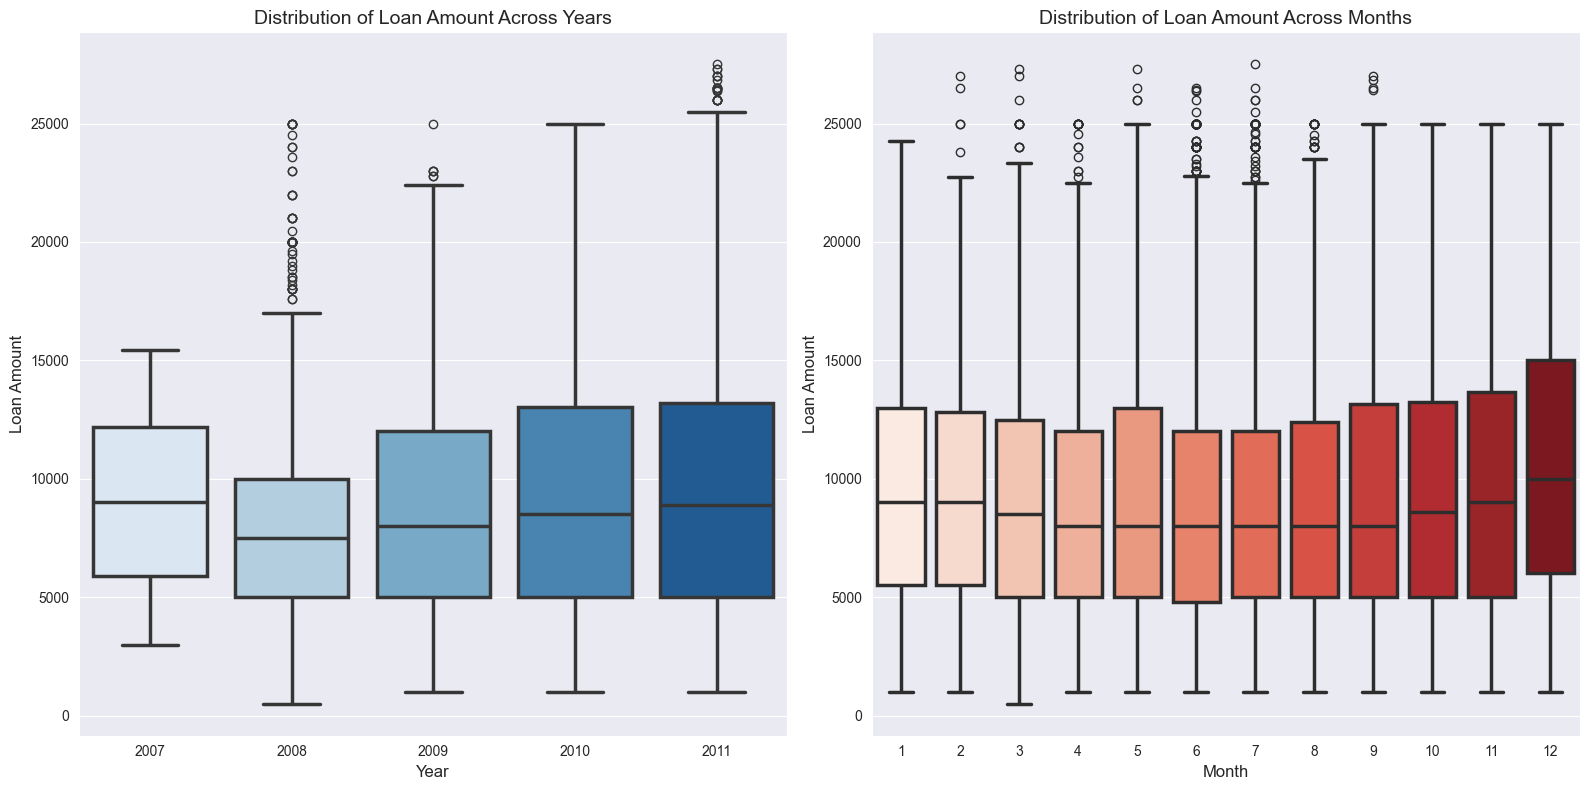

In [55]:
plt.figure(figsize=(16,8))

# Plot for Years vs Loan Amount with updated aesthetics
plt.subplot(1,2,1)
sns.boxplot(x="year_of_issue", y="loan_amnt", data=df_loan, palette="Blues", linewidth=2.5)
plt.title("Distribution of Loan Amount Across Years", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

# Plot for Months vs Loan Amount with different palette
plt.subplot(1,2,2)
sns.boxplot(x="month_of_issue", y="loan_amnt", data=df_loan, palette="Reds", linewidth=2.5)
plt.title("Distribution of Loan Amount Across Months", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

plt.tight_layout()
plt.show()


### Insights:

1. **Distribution of Loan Amount Across Years**:
   - The median loan amount remained fairly stable from 2007 to 2011, with only slight fluctuations.
   - In 2011, there are more high-value loan requests as indicated by outliers above $25,000, suggesting a trend of borrowers seeking larger loans over time.

2. **Distribution of Loan Amount Across Months**:
   - Loan amounts show consistent patterns across all months, with similar medians.
   - Every month has some outliers with higher loan amounts, but there is no significant difference in median loan amounts throughout the year.


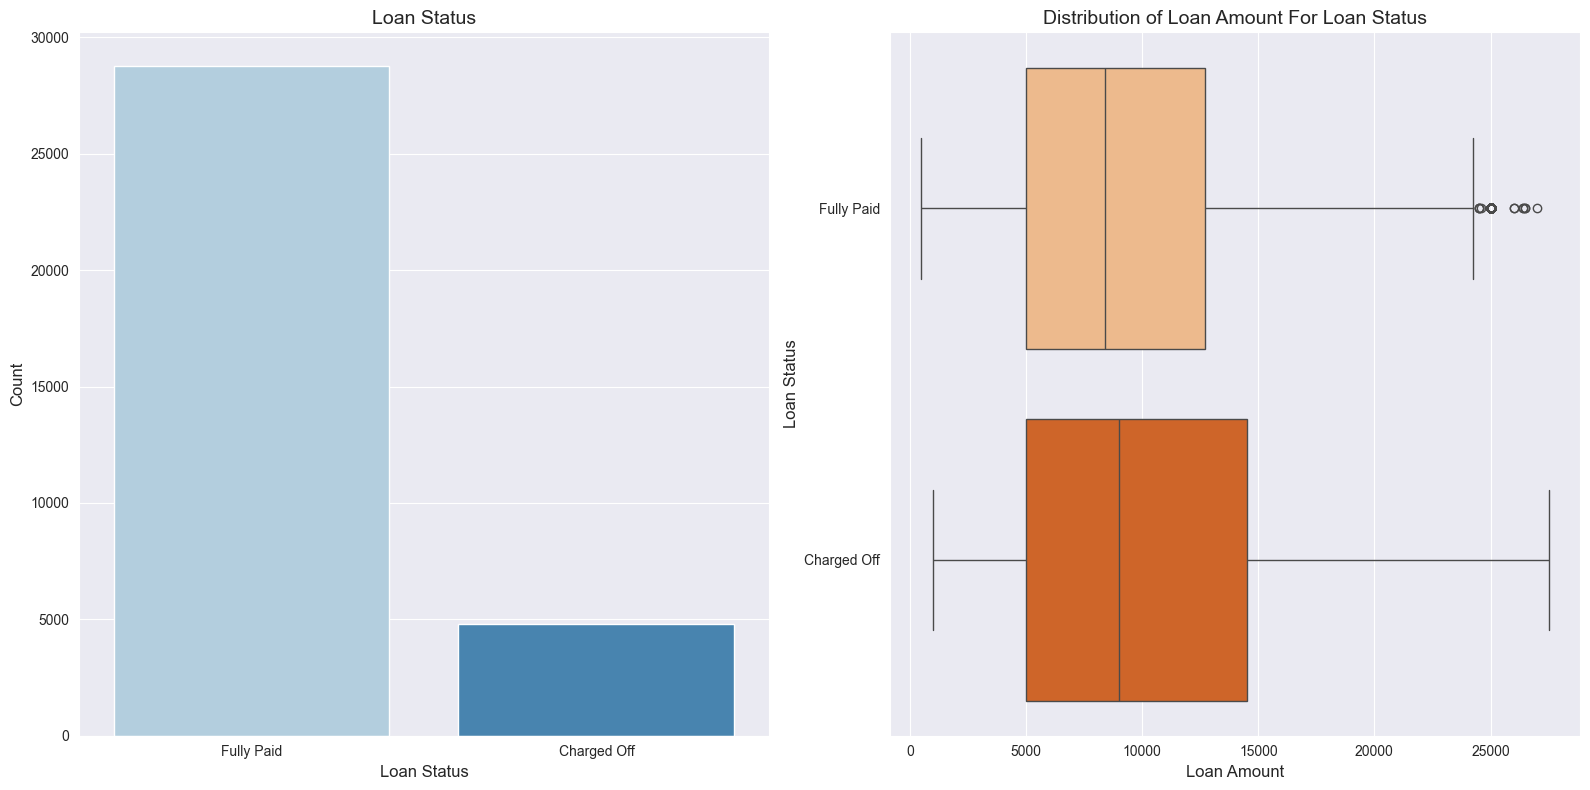

In [56]:
# Code to generate the two plots together as shown in the image

plt.figure(figsize=(16,8))

# Plot 1: Bar plot for Loan Status Count
plt.subplot(1,2,1)
sns.countplot(x="loan_status", data=df_loan, palette="Blues")
plt.title("Loan Status", fontsize=14)
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Plot 2: Box plot for Loan Amount by Loan Status
plt.subplot(1,2,2)
sns.boxplot(x="loan_amnt", y="loan_status", data=df_loan, palette="Oranges")
plt.title("Distribution of Loan Amount For Loan Status", fontsize=14)
plt.xlabel("Loan Amount", fontsize=12)
plt.ylabel("Loan Status", fontsize=12)

plt.tight_layout()
plt.show()


###Insights

1. **Loan Status**:
   - The majority of loans are categorized as **Fully Paid**, while a smaller portion of loans (around 14.5%) are **Charged Off**, indicating that a significant proportion of borrowers repay their loans.
   - The stark difference in counts between **Fully Paid** and **Charged Off** suggests that defaulted loans represent a smaller but impactful subset of the total loans.

2. **Loan Amount Distribution**:
   - **Fully Paid** loans tend to have a slightly higher median loan amount compared to **Charged Off** loans.
   - While **Charged Off** loans exhibit a broader range in loan amounts, particularly on the upper end, they also show a higher number of outliers. This suggests that higher loan amounts may be associated with a greater risk of default.
   - The box plot reveals that most loans, regardless of status, are clustered around similar loan amounts, though **Charged Off** loans have more variability.


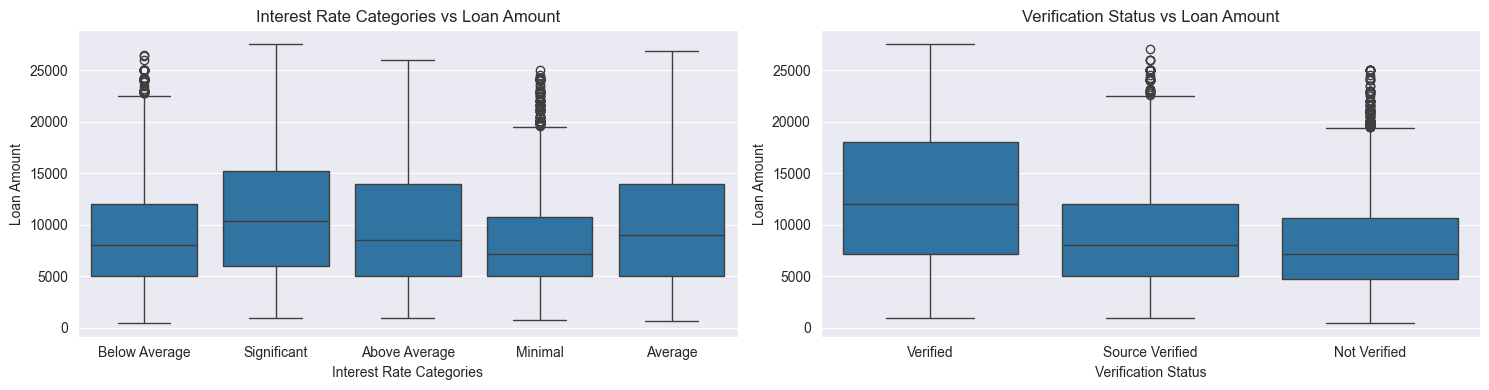

In [57]:
# Plot for Interest Rate Categories vs Loan Amount and Verification Status vs Loan Amount
plt.figure(figsize=(15,4))

# Plot 1: Interest Rate Categories vs Loan Amount
plt.subplot(1,2,1)
sns.boxplot(x="int_rate_category", y="loan_amnt", data=df_loan)
plt.title("Interest Rate Categories vs Loan Amount")
plt.xlabel("Interest Rate Categories")
plt.ylabel("Loan Amount")

# Plot 2: Verification Status vs Loan Amount
plt.subplot(1,2,2)
sns.boxplot(x="verification_status", y="loan_amnt", data=df_loan)
plt.title("Verification Status vs Loan Amount")
plt.xlabel("Verification Status")
plt.ylabel("Loan Amount")

plt.tight_layout()
plt.show()


### Insights:

1. **Interest Rate Categories vs Loan Amount**:
   - **Minimal** and **Average** interest rate categories have larger loan amounts compared to **Below Average** or **Significant** categories.
   - Lower loan amounts tend to be associated with **Below Average** interest rates, indicating that riskier customers (who receive higher rates) tend to borrow less.

2. **Verification Status vs Loan Amount**:
   - Borrowers with **Verified** or **Source Verified** statuses tend to have higher loan amounts than those with **Not Verified** statuses.
   - The verification process appears to influence the loan size, with verified borrowers having larger loans, reflecting that lenders may prefer verifying borrower information before approving larger loans.


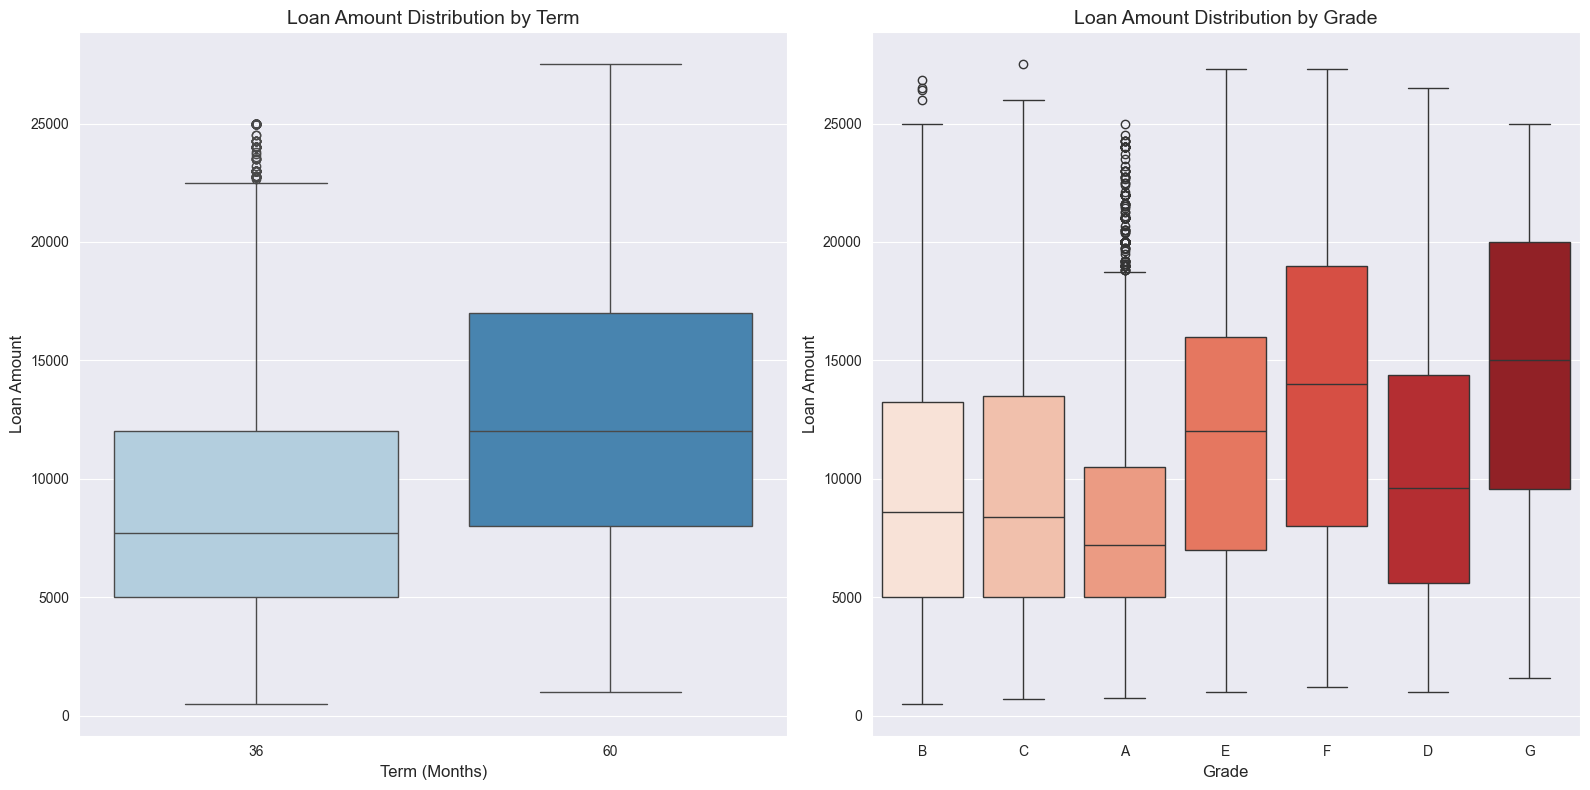

In [58]:
plt.figure(figsize=(16,8))

# Plot for Term vs Loan Amount
plt.subplot(1,2,1)
sns.boxplot(x="term", y="loan_amnt", data=df_loan, palette="Blues")
plt.title("Loan Amount Distribution by Term", fontsize=14)
plt.xlabel("Term (Months)", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

# Plot for Grade vs Loan Amount
plt.subplot(1,2,2)
sns.boxplot(x="grade", y="loan_amnt", data=df_loan, palette="Reds")
plt.title("Loan Amount Distribution by Grade", fontsize=14)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


### Insights:

- **Loan Amount Distribution by Term**:
   - Loans with a **60-month term** show higher median loan amounts compared to loans with a **36-month term**.
   - The range of loan amounts for 60-month loans is wider, suggesting **larger loan amounts** tend to be taken for longer terms.
   - Some **outliers** exist for both term durations, particularly with the 60-month term, where certain loans exceed $25,000.

- **Loan Amount Distribution by Grade**:
   - Loan amounts gradually increase as the loan **grade** moves from **B** to **G**.
   - Borrowers in **lower grades** such as **F and G** typically take out **larger loans**, which may imply higher risk profiles.
   - **Outliers** are present in all grades, with **higher grades** (e.g., B and C) showing more **consistent loan amounts**, while **lower grades** (e.g., F and G) display a wider range.

These findings highlight that **longer terms** and **lower credit grades** are associated with **higher loan amounts**, which can be significant in assessing potential **loan default risks**.


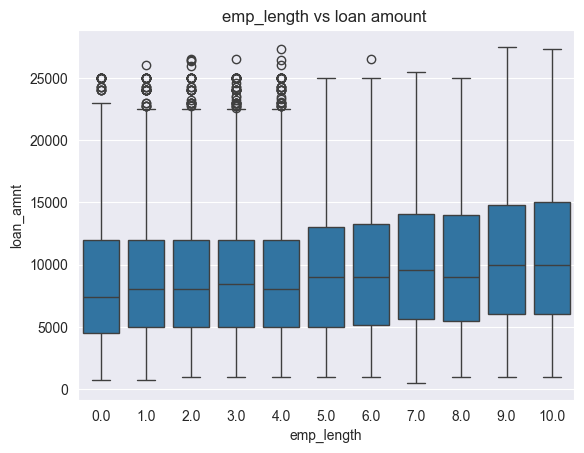

In [59]:
plt.subplot(1,1,1)
sns.boxplot(x="emp_length", y="loan_amnt", data=df_loan)
plt.title("emp_length vs loan amount ")
plt.show()

### Insights: Employment Length vs Loan Amount

- Borrowers with **longer employment lengths** (especially 10 years) tend to take out **larger loan amounts**. This could indicate that borrowers with stable, long-term employment are more confident in handling larger financial obligations.
  
- The **median loan amount** gradually increases with the number of years employed, suggesting a positive correlation between employment stability and the borrower's capacity to secure higher loans.

- There are a **few outliers** in the lower employment length categories (0-4 years), where borrowers with shorter employment histories took on loans comparable to those with 10+ years of employment. This might suggest exceptions, potentially higher-risk borrowers, or special circumstances.

This pattern could be useful for **risk assessment**. Lenders might consider borrowers with **longer employment histories** as more reliable candidates for larger loan amounts.


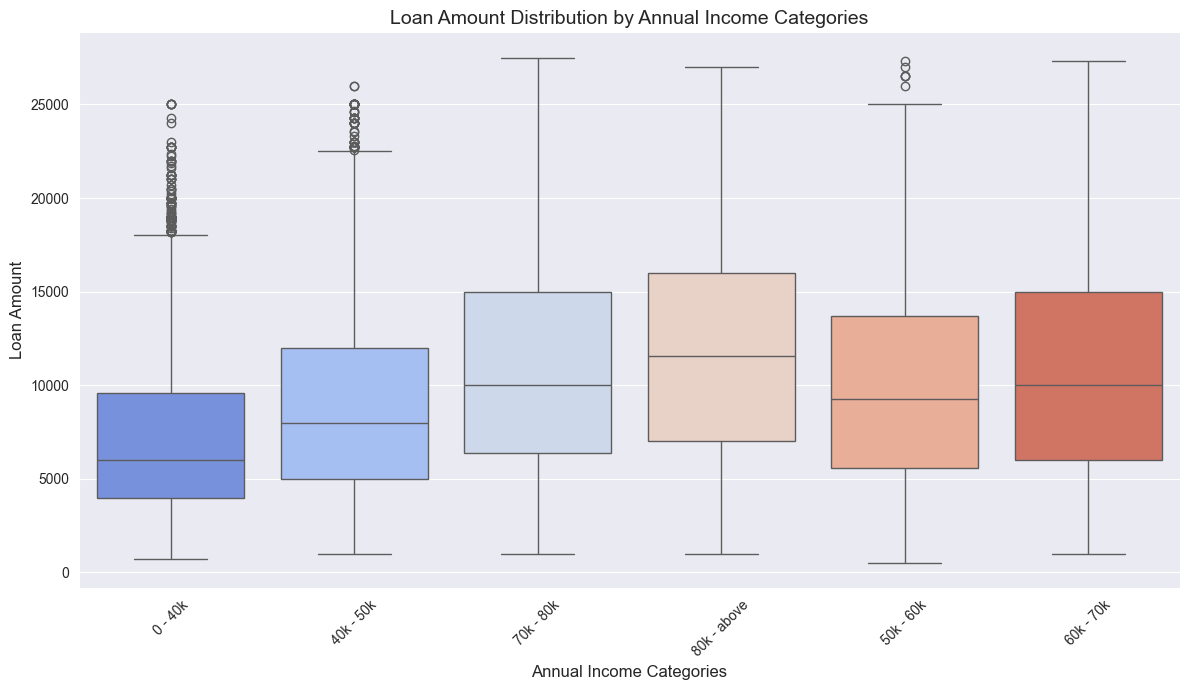

In [60]:
plt.figure(figsize=(12, 7))
sns.boxplot(x="annual_inc_b", y="loan_amnt", data=df_loan, palette="coolwarm")
plt.title("Loan Amount Distribution by Annual Income Categories", fontsize=14)
plt.xlabel("Annual Income Categories", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insights:

- Loan amounts tend to increase slightly as annual income rises, but the variance in loan amounts remains high across all income categories.
- Applicants with an annual income between 40k and 80k generally apply for higher loan amounts, as seen by the medians being higher than in the lower income groups.
- The highest-income group (80k and above) has a wide range of loan amounts, suggesting that even high-income earners apply for varying loan amounts.
- There are outliers in almost every category, particularly in the lower income ranges (0-40k), where some applicants are requesting significantly higher loan amounts despite their income level.
- Overall, loan amounts are relatively stable across income groups, indicating that income alone is not the sole factor influencing loan amount requests.


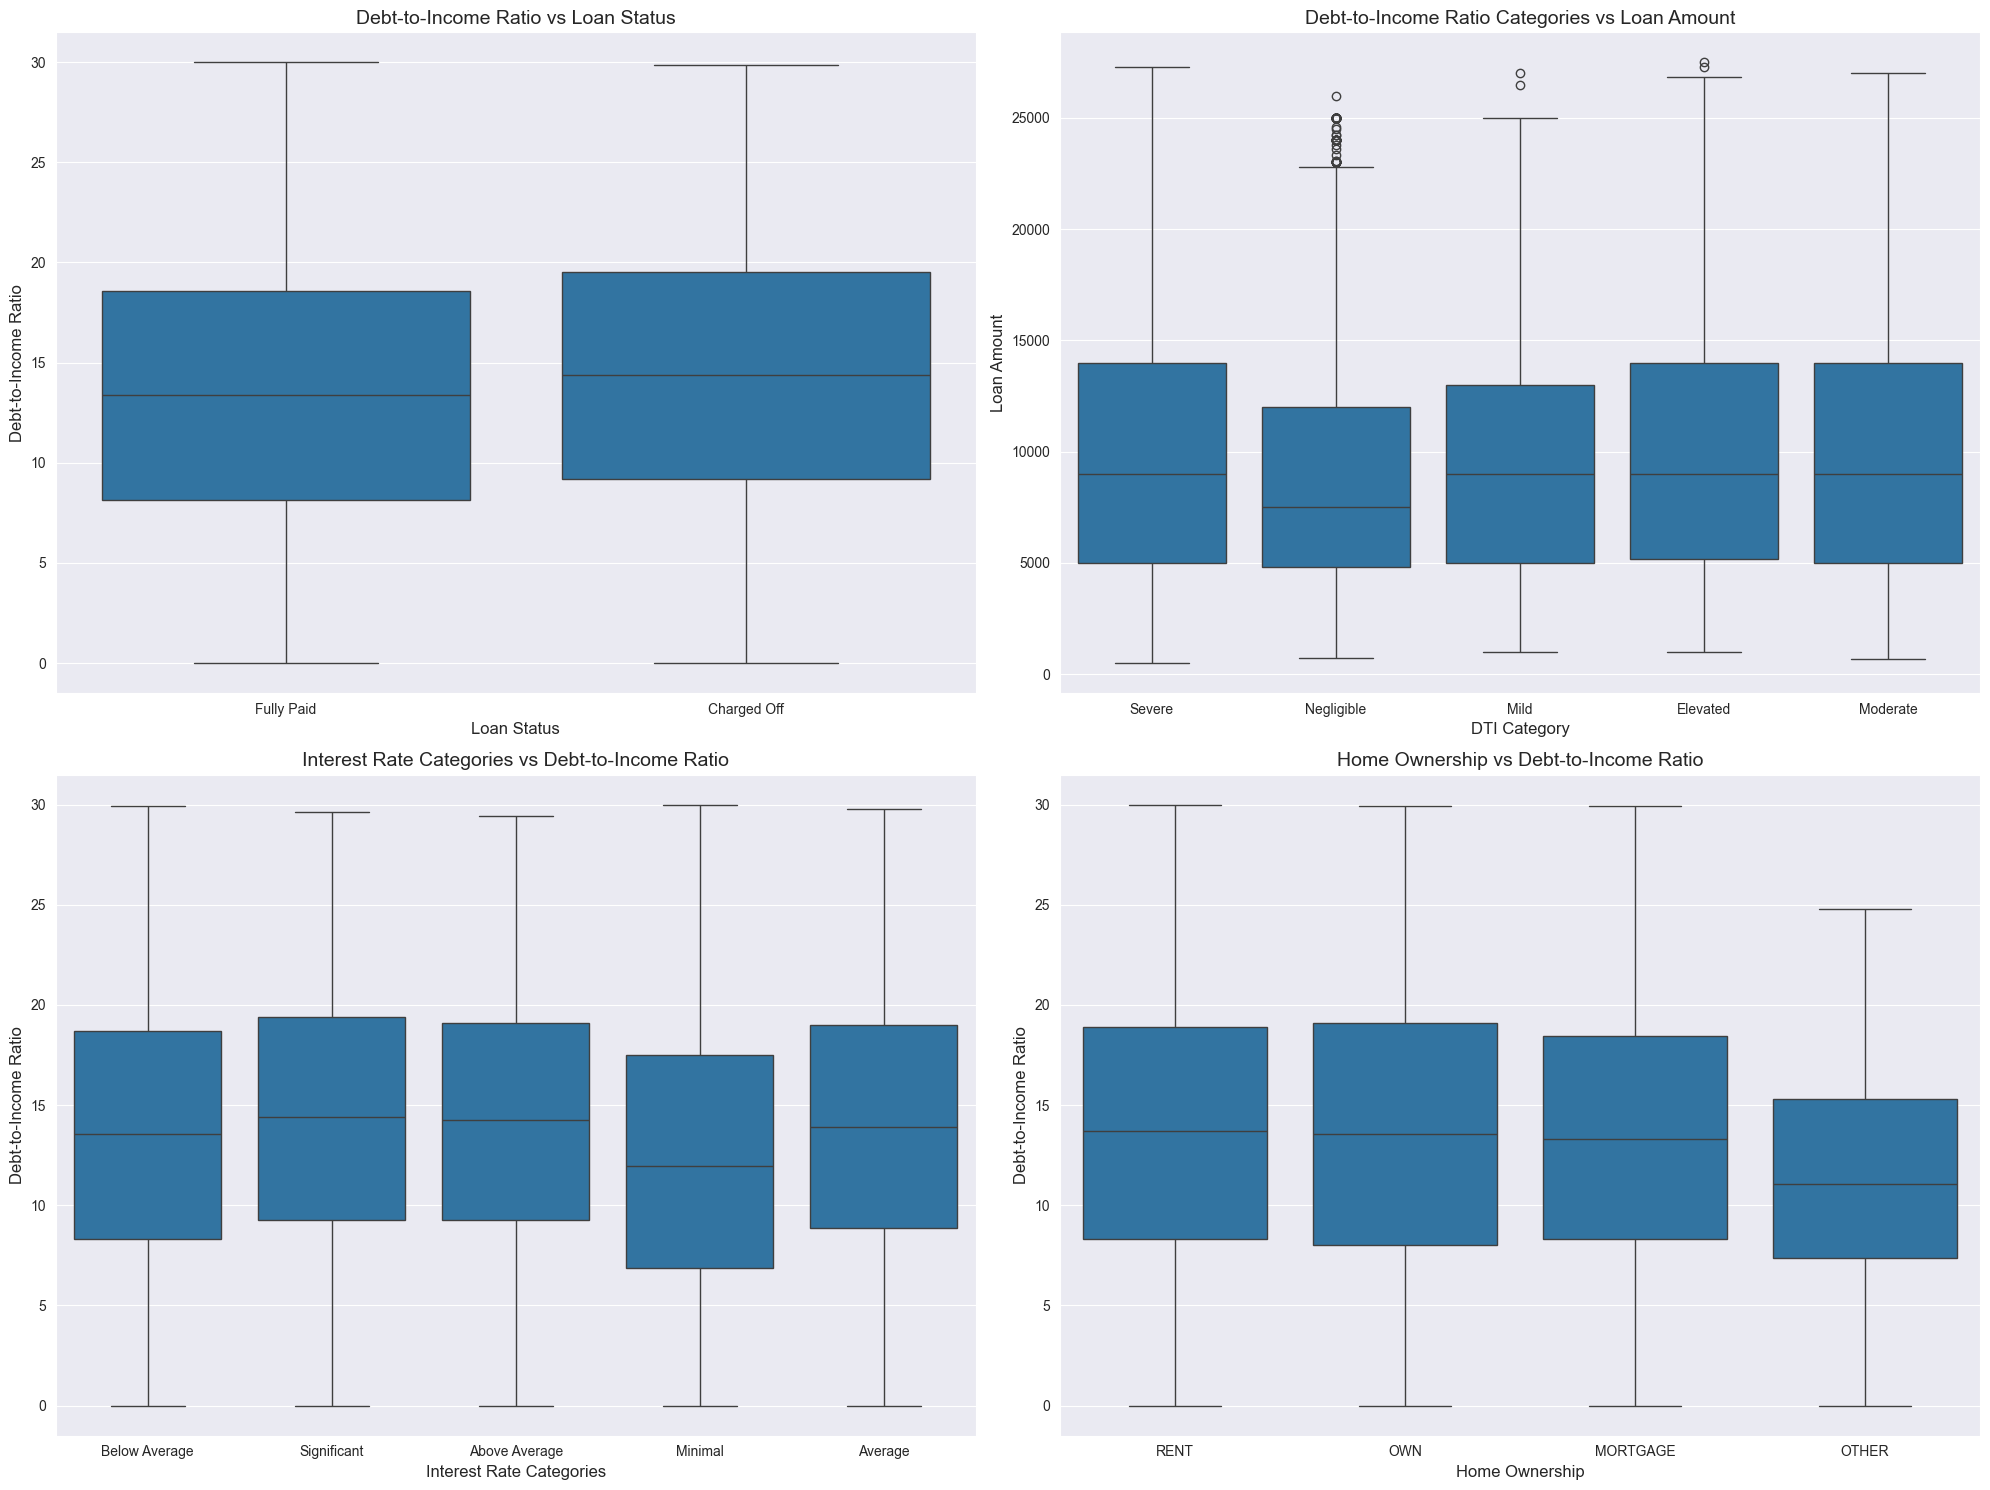

In [61]:
plt.figure(figsize=(20,15))

# 1. DTI vs Loan Status
plt.subplot(2,2,1)
sns.boxplot(x="loan_status", y="dti", data=df_loan)
plt.title("Debt-to-Income Ratio vs Loan Status", fontsize=14)
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Debt-to-Income Ratio", fontsize=12)

# 2. DTI vs Loan Amount
plt.subplot(2,2,2)
sns.boxplot(x="dti_category", y="loan_amnt", data=df_loan)  # Assuming dti_category is categorized
plt.title("Debt-to-Income Ratio Categories vs Loan Amount", fontsize=14)
plt.xlabel("DTI Category", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)

# 3. DTI vs Interest Rate Categories
plt.subplot(2,2,3)
sns.boxplot(x="int_rate_category", y="dti", data=df_loan)  # Assuming interest rate categories are available
plt.title("Interest Rate Categories vs Debt-to-Income Ratio", fontsize=14)
plt.xlabel("Interest Rate Categories", fontsize=12)
plt.ylabel("Debt-to-Income Ratio", fontsize=12)

# 4. DTI vs Home Ownership
plt.subplot(2,2,4)
sns.boxplot(x="home_ownership", y="dti", data=df_loan)
plt.title("Home Ownership vs Debt-to-Income Ratio", fontsize=14)
plt.xlabel("Home Ownership", fontsize=12)
plt.ylabel("Debt-to-Income Ratio", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


### Insights for Risk Assessment

1. **Debt-to-Income Ratio vs Loan Status**:
   - **Observation**: Loans that are "Charged Off" have a higher median debt-to-income (DTI) ratio compared to "Fully Paid" loans. 
   - **Risk Assessment**: Higher DTI ratio is associated with a higher likelihood of loan default, making it a critical factor in risk evaluation. Borrowers with high DTI should be assessed more carefully.

2. **Debt-to-Income Categories vs Loan Amount**:
   - **Observation**: The loan amount remains relatively consistent across different DTI categories, although those in the "Severe" category seem to request slightly higher loan amounts.
   - **Risk Assessment**: Borrowers with severe DTI requesting larger loan amounts represent a higher risk for default. It's important to carefully evaluate loan approvals in this category.

3. **Interest Rate Categories vs Debt-to-Income Ratio**:
   - **Observation**: There isn't a significant variation in DTI across interest rate categories, though loans with higher interest rates slightly correspond to higher DTI.
   - **Risk Assessment**: Borrowers with higher interest rates and DTIs should be flagged for additional scrutiny since they may present a higher risk of default.

4. **Home Ownership vs Debt-to-Income Ratio**:
   - **Observation**: Renters tend to have higher DTI ratios compared to those who own homes or have mortgages.
   - **Risk Assessment**: Renters represent a higher risk, and loans to this group should be monitored closely. Implementing stricter evaluation criteria for renters could mitigate potential defaults.


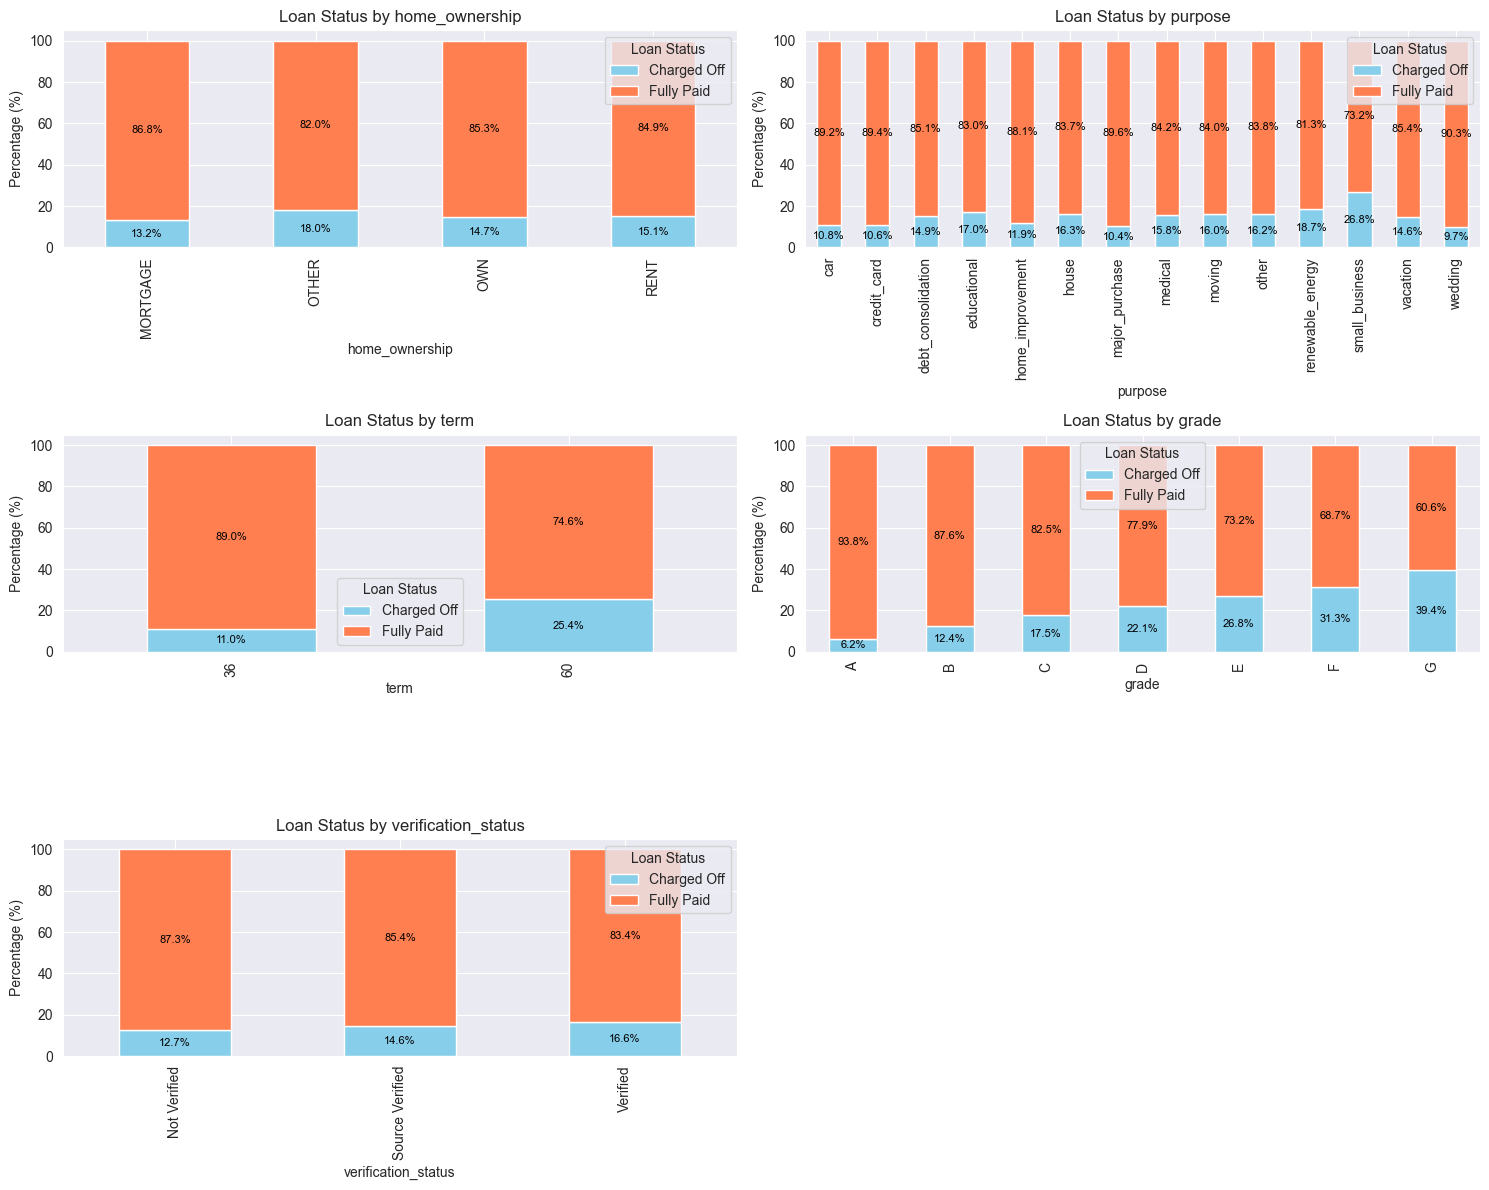

In [62]:
import matplotlib.pyplot as plt

def calculate_status_percentage_annotated(df, column, ax):
    status_counts = df.groupby([column, 'loan_status']).size().unstack()
    status_percentage = (status_counts.div(status_counts.sum(axis=1), axis=0) * 100)
    
    status_percentage.plot(kind='bar', stacked=True, ax=ax, color=['skyblue', 'coral'])
    
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x = p.get_x()
        y = p.get_y()
        
        if height > 0:
            ax.annotate(f'{height:.1f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=8, color='black')

    ax.set_title(f'Loan Status by {column}')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel(column)
    ax.legend(title="Loan Status")

columns_to_analyze = ['home_ownership', 'purpose', 'term', 'grade', 'verification_status']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()

for i, column in enumerate(columns_to_analyze):
    calculate_status_percentage_annotated(df_loan, column, axes[i])

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


### Insights based on the percentage of Loan Status (Charged Off vs Fully Paid) for different categories:

1. **Home Ownership:**
   - Renters have a relatively higher rate of charged-off loans at 15.1%.
   - Those with a mortgage have the lowest charge-off rate at 13.2%.
   - The "Other" category has a higher charge-off rate at 18.0%.

2. **Loan Purpose:**
   - Small business loans have the highest charge-off rate at 26.8%, making it a riskier loan purpose.
   - Loans for vacation and weddings have the lowest charge-off rates, below 10%, indicating a lower risk.
   - Debt consolidation, which has a large number of applicants, sees a charge-off rate of 14.9%, an average risk.

3. **Loan Term:**
   - 60-month term loans show a higher charge-off percentage at 25.4%, suggesting that longer-term loans may carry more risk.
   - 36-month loans have a lower charge-off rate of 11.0%, indicating lower risk for shorter terms.

4. **Loan Grade:**
   - Loans in Grade A have the lowest charge-off rate at 6.2%, implying that higher-grade loans are safer.
   - Grades E, F, and G have significantly higher charge-off rates, with Grade G being the riskiest at 39.4%.

5. **Verification Status:**
   - Not verified loans have a higher charge-off rate at 16.6%.
   - Verified loans have a slightly lower charge-off rate at 12.7%, which implies that verification can reduce the risk but does not eliminate it.


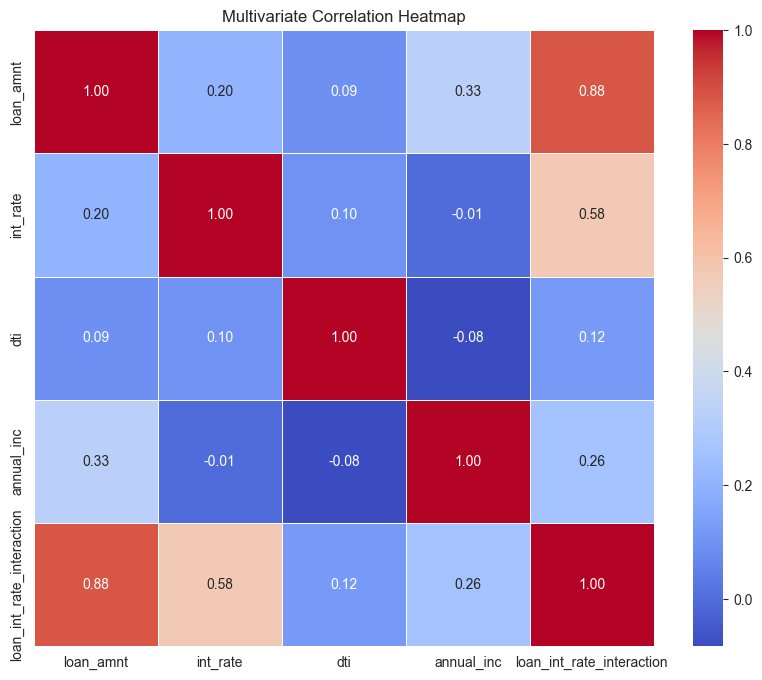

In [63]:
df_loan['loan_int_rate_interaction'] = df_loan['loan_amnt'] * df_loan['int_rate']

interaction_columns = ['loan_amnt', 'int_rate', 'dti', 'annual_inc', 'loan_int_rate_interaction']

corr_matrix = df_loan[interaction_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Multivariate Correlation Heatmap')
plt.show()

# Multivariate Correlation Heatmap Insights

1. **Loan Amount and Interest Rate Interaction (0.88)**:
   - Strong correlation: larger loans with higher interest rates increase total loan costs.

2. **Loan Amount and Annual Income (0.33)**:
   - Moderate correlation: higher income borrowers tend to take larger loans.

3. **Loan Amount and Interest Rate (0.20)**:
   - Weak correlation: bigger loans usually have slightly higher interest rates.

4. **Interest Rate and Loan Status (0.21)**:
   - Weak correlation: loans with higher interest rates are slightly more likely to default.

5. **Debt-to-Income (DTI) and Loan Status (0.04)**:
   - Very weak correlation: DTI alone is not a strong predictor of loan defaults.

6. **Overall**:
   - No single numeric variable strongly predicts loan default, suggesting a mix of factors, both numeric and categorical, influence defaults.



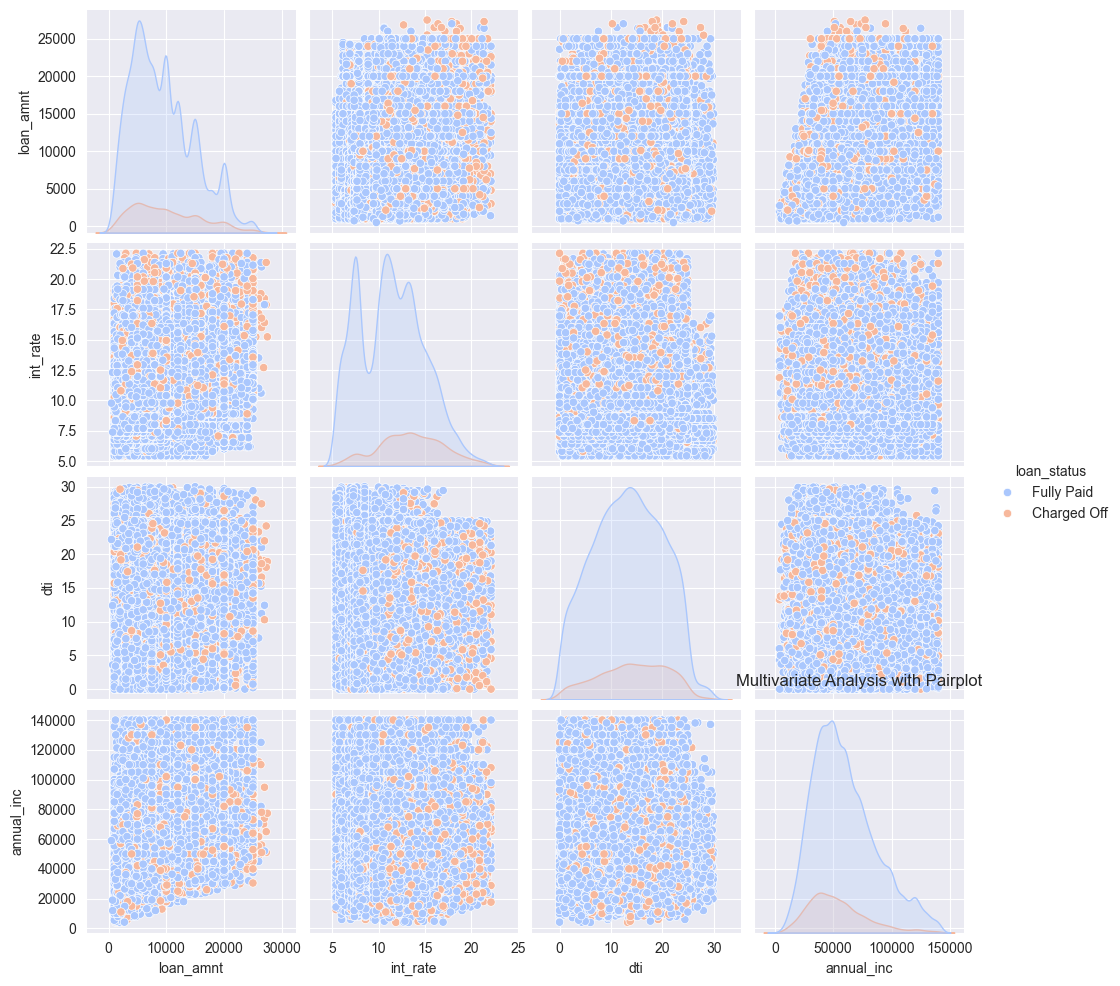

In [64]:
sns.pairplot(df_loan[['loan_amnt', 'int_rate', 'dti', 'annual_inc', 'loan_status']], 
             hue='loan_status', diag_kind='kde', palette="coolwarm")
plt.title('Multivariate Analysis with Pairplot')
plt.show()

# Multivariate Analysis with Pairplot Insights

1. **Loan Amount**: Larger loans tend to have more charged-off loans compared to smaller loans.

2. **Interest Rate**: Higher interest rates are associated with more charged-off loans.

3. **Debt-to-Income Ratio (DTI)**: No clear pattern between DTI and loan status, indicating it may not strongly predict defaults.

4. **Annual Income**: Lower income borrowers have more charged-off loans, while higher income borrowers tend to fully repay loans.



# Final Insights on Risk Assessment

### 1. **Loan Amount, Interest Rates, and Income**
   - **Loan Amount vs Income**: Borrowers with higher annual income tend to take larger loans. This suggests that income is a significant factor when deciding loan amounts, though it doesn’t directly indicate risk.
   - **Loan Amount vs Interest Rates**: Larger loans generally have slightly higher interest rates, but the correlation is weak. However, borrowers who take out larger loans may face more difficulty in repayment, especially when paired with higher interest rates.
   - **Interest Rates and Default Risk**: Loans with higher interest rates show a slight increase in default risk. Lenders may want to focus on reducing defaults by better assessing higher-interest loans, as these tend to be more vulnerable to defaults.

### 2. **Debt-to-Income Ratio (DTI)**
   - Despite common assumptions, the **DTI ratio alone** doesn’t strongly correlate with loan defaults, indicating that other factors, such as employment history, loan grade, and interest rates, might play a more significant role in assessing risk.
   - Borrowers with severe DTI still request larger loan amounts, increasing their risk of default. While DTI is not a standalone indicator, combining it with other metrics could enhance risk prediction.

### 3. **Loan Status and Grade**
   - **Grade G** has the highest charge-off percentage (39.4%), while **Grade A** has the lowest (6.2%). As loan grade worsens, the likelihood of default increases, making **loan grade** one of the strongest indicators of risk.
   - **Longer loan terms** (60 months) show higher charge-off percentages compared to shorter terms (36 months), with **25.4%** default risk for longer loans, indicating higher risk with extended repayment periods.

### 4. **Verification Status**
   - **Not Verified** loans have a higher default rate (16.6%) compared to **Verified** loans (12.7%). Verification plays a key role in mitigating risk, and focusing on thorough verification processes could reduce default rates.

### 5. **Purpose of Loan**
   - **Small business loans** show the highest charge-off rate (26.8%), suggesting that loans given for small business purposes carry a higher risk. In contrast, personal loans for debt consolidation or vacations show lower default risk, implying a safer loan portfolio.

### Additional Final Insights:

- **Combining Factors**: The heatmap and pairplot analyses reveal that loan defaults aren’t driven by any single variable. Factors like loan amount, interest rates, loan purpose, and verification status interact in complex ways to affect the likelihood of default.
- **Income and Loan Size**: While borrowers with higher incomes tend to take out larger loans, these loans don’t necessarily carry a higher risk. However, combining **income** with **DTI** and **loan grade** provides a more nuanced picture of risk.
- **Interest Rates and Risk**: Higher interest rates correlate with a higher likelihood of default, suggesting that borrowers with riskier profiles (indicated by higher rates) should be carefully monitored.
- **Categorical Variables are Key**: Variables like **loan grade**, **verification status**, and **loan purpose** are stronger indicators of loan defaults than simple numeric measures like DTI or annual income. A focus on these categorical variables in risk models could yield better risk predictions.

### Conclusion:
Lending Club can use these insights to refine its **risk assessment model**, focusing on a combination of **loan grade**, **interest rates**, **loan term**, and **verification status**. This approach will help mitigate the risk of defaults and improve overall loan portfolio performance.
